In [3]:

# from openai_prompt_templates import make_direct_output_prompt
import sys
import os
# from openai_prompts import make_direct_output_prompt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

sys.path.append("../") # 
from alex_utils import load_lines, is_equal_
# lines = load_lines("/fsx-onellm/gua/Documents/datasets/output_prediction/output_prediction_function_30B.jsonl")

sys.path.append("../scripts/sida/")
import importlib
import analyze_ops
importlib.reload(analyze_ops)
sns.set_style("ticks")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

"""
can you check if this file is in a format easy for you to analyze: /fsx-onellm/gua/Documents/CodeGen-xlformers/distilled_experiments/full_eval/all_data_final.json

i recommend to use it like this:
data = json.load(open("all_data_final.json", "r"))
data = {eval(k): {eval(_k): _v for _k, _v in v.items()} for k, v in data.items()}

the keys of data are the id's in the data file, like (1627, 25, 1)
then, data[(1627, 25, 1)] is another dictionary, where the keys are like ('input'/'output', model, temperature) and the values are [generations, [execution results, score]]

to get the code, inputs, outputs, etc. corresponding to each id, you can use the data file: /fsx-onellm/gua/Documents/datasets/output_prediction/output_prediction_final.jsonl

Download figures:
rsync -avz -e 'ssh -p 1233' localhost:/fsx-codegen/sida/git/CodeGen-xlformers/distilled_experiments/figs exec-bench
"""
modelinfo_path = '/fsx-codegen/sida/git/CodeGen-xlformers/scripts/sida/model_info.tsv'

def load_info():
    df_info = pd.read_csv(modelinfo_path, sep='\t')
    # sns.set_theme()

    def f(x):
        if str(x['display_name']) == 'nan':
            x['display_name'] = x['model']
        # print(x)
        return x
    df_info = df_info.apply(f, axis=1)
    return df_info

df_info = load_info()
display(df_info)

name_translation = df_info[['model', 'display_name']].set_index('model').to_dict()['display_name']
print(name_translation)
# name_translation = {'phi': 'phi15'}

,model,size,family,cot,training,HumanEval@1,EvalPlus,MBPP@1,display_name
0,codellama_13B,13.000,llama,False,base,0.360,0.370,NaN,codellama_13B
1,codellama_30B,34.000,llama,False,base,0.490,0.430,NaN,codellama_34B
2,codellama_7B,7.000,llama,False,base,0.340,0.340,NaN,codellama_7B
3,codellama_cot13B,13.000,llama,True,base,NaN,NaN,NaN,codellama_cot13B
4,codellama_cot30B,34.000,llama,True,base,NaN,NaN,NaN,codellama_cot34B
5,codellama_python_13B,13.000,llama,False,base,0.430,NaN,NaN,codellama_py_13B
6,codellama_python_30B,34.000,llama,False,base,0.540,NaN,NaN,codellama_py_34B
7,codellama_python_7B,7.000,llama,False,base,0.380,NaN,NaN,codellama_py_7B
8,gpt35,99.000,gpt,False,instruct,0.760,0.640,NaN,gpt35
9,gpt35_cot,99.000,gpt,True,instruct,NaN,NaN,NaN,gpt35_cot


{'codellama_13B': 'codellama_13B', 'codellama_30B': 'codellama_34B', 'codellama_7B': 'codellama_7B', 'codellama_cot13B': 'codellama_cot13B', 'codellama_cot30B': 'codellama_cot34B', 'codellama_python_13B': 'codellama_py_13B', 'codellama_python_30B': 'codellama_py_34B', 'codellama_python_7B': 'codellama_py_7B', 'gpt35': 'gpt35', 'gpt35_cot': 'gpt35_cot', 'gpt4': 'gpt4', 'gpt4_cot': 'gpt4_cot', 'mistral': 'mistral', 'phi': 'phi1.5', 'phi1': 'phi1', 'phind34b': 'phind_34B', 'starcoder16b': 'starcoder_16B', 'starcoder7b': 'starcoder_7B', 'wizard13b': 'wizard_13B', 'wizard34b': 'wizard_34B', 'deepseek-instruct7b': 'deepseek_ins_7B', 'deepseek-instruct33b': 'deepseek_ins_33B', 'deepseek-base7b': 'deepseek_7B', 'deepseek-base33b': 'deepseek_33B'}


In [4]:
def pass_at_k(n, c, k):
    """
    :param n: total number of samples
    :param c: number of correct samples
    :param k: k in pass@$k$
    """
    if n - c < k:
        return 1.0
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

def result_to_df(path):
    global models, models_trans
    data = json.load(open(path, "r"))
    data = {eval(k): {eval(_k): _v for _k, _v in v.items()} for k, v in data.items()}
    print('finished eval')
    records = []
    models = set([k[1] for k in list(data.items())[0][1].keys()])
    print()
    models_trans = set([name_translation[m] for m in models])
    temps = set([k[2] for k in list(data.items())[0][1].keys()])
    print('models', len(models))
    print('models_trans', len(models_trans))
    print('temps', temps)
    for id in tqdm(data):
        for t in temps:
            for m in models:
                for task in ['input', 'output']:
                    key = (task, m, t)
                    if key in data[id]:
                        p = data[id][key][1][1]
                        generations = data[id][key][0]
                        n = len(generations) 
                        id_str = ','.join([str(i) for i in id])
                        pass5 = pass_at_k(n, n*p, 5)
                        pass1 = pass_at_k(n, n*p, 1)
                        records.append({'id': id_str, 'pass1': pass1, 'pass5': pass5, 'task': task, 'model': name_translation[m], 't': t, 'n': n, 'c': n*p, 'generations': generations})
    return pd.DataFrame.from_records(records)


def data_to_df(datapath):
    lines = load_lines(datapath)
    records = []
    for test in lines:
        # dict_keys(['id', 'method', 'code', 'code_challenge', 'input', 'output', 'nll_input_prediction', 'nll_output_prediction', 'generated_inputs', 'generated_inputs_raw', 'generated_inputs_results', 'generated_inputs_score', 'generated_outputs', 'generated_outputs_raw', 'generated_outputs_results', 'generated_outputs_score', 'input_hard', 'output_hard'])
        # print(test.keys())
        selected_keys = ['id', 'input', 'method', 'code', 'code_challenge', 'output'] 
        r = {k: test[k] for k in selected_keys}
        measure_lens = ['input', 'output', 'code']
        for k in measure_lens:
            r[f'{k}_len'] = len(r[k])
        r['id'] = ','.join([str(i) for i in r['id']])

        # if 'generated_outputs_gpt_score' in r:
        #     r['generated_outputs_gpt_score'] = r['generated_outputs_gpt_score'] + np.random.randn() * 0.005
        r['method_type'] = r['method'].split('.')[0]
        records.append(r)

    return pd.DataFrame.from_records(records)

result_path = '/fsx-onellm/gua/Documents/CodeGen-xlformers/distilled_experiments/full_eval/all_data_final_new.json'
data_path = '/fsx-onellm/gua/Documents/datasets/output_prediction/output_prediction_final.jsonl'

df_data = data_to_df(data_path)
df_result = result_to_df(result_path)


finished eval

models 24
models_trans 24
temps {0.8, 0.0, 0.2}


100%|██████████| 2000/2000 [00:03<00:00, 534.02it/s]


In [5]:
importlib.reload(analyze_ops)
def execution_annotation(df, verbose = False):
    records = []
    n = len(df)
    # for i in list(range(0000, 90000)) + list(range(100000, n)):
    # 94870
    for i in list(range(0, n)):
        if i % (n / 20) == 0:
            print(f'{i/n*100:.2f}%')
        code, id = df.iloc[i][['code_challenge', 'id']]
        code += ' ' + df.iloc[i]['output']

        if verbose:
            print(i)
            print(code)

        exec_info = analyze_ops.annotate(code)
        r = {'id': id}
        r.update(exec_info)
        r.update({'is_bad': len(exec_info['bad']) > 0})
        records.append(r)
    
    # print(records)
    records = np.random.permutation(records)
    execution_info = pd.DataFrame.from_records(records)
    # execution_info.to_csv('execution_info.csv', index_label='num')
    return execution_info, records

# calling this again will shuffle the data again
# execution_info, records = execution_annotation(df_data, verbose=False)
execution_info = pd.read_csv('execution_info_800.csv', index_col='num')
display(execution_info)
merged = pd.merge(execution_info, df_data, on='id')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
summary = merged.describe().transpose()
# summary.sort_index()
display(summary)

print('remaining')
display(merged[merged['is_bad'] == False].describe().transpose())
merged.to_csv('annotated.csv')

# types = ['str', 'dict', 'list']
# for t in types:
#     print(t)
#     display(merged[merged['method_type'] == t].describe().transpose()[['count', 'mean', '50%']])
#     display(merged[(merged['method_type'] == t) & merged['is_bad']].describe().transpose()[['count', 'mean', '50%']])

,id,num_ins,bad,numsteps,is_bad,is_main
num,,,,,,
0,"973,11,4",14,Counter(),50.000,False,True
1,"1760,1,1",19,Counter(),47.000,False,True
2,"1536,21,3",14,Counter(),231.000,False,True
3,"805,14,3",18,Counter(),104.000,False,True
4,"587,30,0",14,Counter(),43.000,False,True
...,...,...,...,...,...,...
1995,"1734,29,2",14,Counter(),51.000,False,False
1996,"672,14,2",22,Counter(),31.000,False,False
1997,"1575,41,1",16,Counter(),147.000,False,False


,count,mean,std,min,25%,50%,75%,max
num_ins,2000.000,15.967,3.751,0.000,14.000,15.000,18.000,44.000
numsteps,1958.000,88.390,138.289,19.000,34.000,50.000,98.000,3175.000
input_len,2000.000,19.256,14.066,0.000,9.000,16.000,25.250,128.000
output_len,2000.000,12.882,12.032,1.000,4.000,9.000,18.000,50.000
code_len,2000.000,139.660,58.972,28.000,95.000,136.000,180.250,281.000


remaining


,count,mean,std,min,25%,50%,75%,max
num_ins,1752.000,16.286,3.048,14.000,14.000,15.000,18.000,44.000
numsteps,1752.000,84.148,118.896,23.000,34.000,49.000,94.000,3175.000
input_len,1752.000,19.092,13.884,0.000,9.000,16.000,25.000,128.000
output_len,1752.000,12.505,11.740,1.000,4.000,9.000,18.000,50.000
code_len,1752.000,137.046,58.773,28.000,92.000,134.000,177.000,281.000


In [6]:
_merged = pd.merge(execution_info, df_data, on='id')
# display(_merged.head(10))
# display(df_result.head(10))
annotated_res = pd.merge(_merged, df_result, on='id')

def get_wide(df):
    df_hight= df[(df['t'] == 0.8) & (df['is_bad'] == False)].reset_index()
    df_lowt = df[(df['t'] == 0.2) & (df['is_bad'] == False)].reset_index()
    # display(df)
    df_wide_lowt = df_lowt[['id', 'task', 'model', 'pass1', 'n', 'c']].pivot(index=['id'], columns=['model', 'task'], values=['pass1', 'n', 'c'])
    df_wide_hight = df_hight[['id', 'task', 'model', 'pass5', 'n', 'c']].pivot(index=['id'], columns=['model', 'task'], values=['pass5'])
    df_wide = df_wide_lowt.merge(df_wide_hight, on='id')
    return df_wide

df_wide = get_wide(annotated_res)
display(df_wide.head(5))

pass1                                                     \
model     deepseek_7B        codellama_cot34B        starcoder_7B          
task            input output            input output        input output   
id                                                                         
10,22,0         0.930  0.080            0.900  0.200        1.000  0.000   
1001,12,2       0.610  0.000            0.900  1.000        0.000  1.000   
1001,37,1       0.290  0.000            1.000  0.300        0.260  0.000   
1001,4,3        0.000  0.980            0.000  0.200        0.000  0.000   
1002,19,0       0.000  0.000            0.100  0.500        0.000  0.000   

                                                 ...         pass5         \
model     codellama_7B        wizard_34B         ... codellama_34B          
task             input output      input output  ...         input output   
id                                               ...                        
10,22,0          0.410  0.040      0.310  0.000  ...         1.000  0.681   
1001,12,2        0.020  1.000      0.000  1.000  ...         0.994  1.000   
1001,37,1        0.420  0.000      0.340  0.000  ...         0.949  0.188   
1001,4,3         0.000  0.000      1.000  0.000  ...         0.416  0.271   
1002,19,0        0.040  0.000      0.000  0.000  ...         0.839  0.098   

                                                                               \
model     deepseek_ins_33B        codellama_13B        codellama_py_7B          
task                 input output         input output           input output   
id                                                                              
10,22,0              0.999  0.907         1.000  0.614           1.000  0.701   
1001,12,2            1.000  0.347         0.872  1.000           0.382  1.000   
1001,37,1            0.907  0.000         0.954  0.814           0.986  0.914   
1001,4,3             0.998  0.998         0.382  0.969           0.050  0.144   
1002,19,0            0.382  0.000         0.814  0.050           0.786  0.188   

                        
model      phi1         
task      input output  
id                      
10,22,0   1.000  0.416  
1001,12,2 0.000  0.954  
1001,37,1 0.449  0.000  
1001,4,3  0.000  0.098  
1002,19,0 0.000  0.000  

[5 rows x 192 columns]

## Decide on the size of data

currently decided on 800, justified below

In [7]:
def doresample(r, task):
    for model in models_trans:
        n = r[('n', model, task)]
        c0 = r[('c', model, task)]
        c = np.random.binomial(10, c0/n)
        r[('pass1', model, task)] = c / n
            # r[('pass5', model, task)] = pass_at_k(10, c, 5)
    # print(r)
    return r
    # print('next')

# raw = df_wide.sample(10, replace=True)[['n', 'c']]
# raw = raw.apply(resample, axis=1)
# display(raw[['pass1', 'pass5']])
# print(raw.columns)

def get_intervals(df_wide, task = 'output', passk='pass1', B=10000, resample=False):
    def boostrap_diff(n_data, pair, B=10):
        samps = []
        for i in range(B):
            draw10 = df_wide.sample(n_data, replace=True)
            if resample:
                draw10 = draw10.apply(lambda x: doresample(x, task), axis=1)
            samps.append(draw10.aggregate('mean', axis=0))

        means = pd.concat(samps, axis=1).transpose()
        means = means[passk]
        return means[pair[0]][task] - means[pair[1]][task]

    selected = [
        ('codellama_34B', 'codellama_13B'),
        # ('codellama_13B', 'codellama_7B'),
        # ('gpt35', 'deepseek_ins_33B'),
        # ('gpt4', 'gpt35'),
        ('codellama_cot34B', 'codellama_34B'),
        ('deepseek_ins_33B', 'codellama_34B'),
        # ('deepseek-instruct7b', 'codellama_7B'),
    ]
    errors = []
    for t in selected:
        sizes = np.random.randint(50, 2001, size=(100,))
        errors += [{'data size': n, 'diff': d, 'type': f'{t[0]} - {t[1]}'} for n in sizes for d in boostrap_diff(n, t, B=5)]
    wrong_chance = pd.DataFrame.from_records(errors)


    errors = []
    for t in selected:
        sizes = [200, 400, 800, 1600]
        errors += [{'data size': n, 'diff': d, 'type': f'{t[0]} - {t[1]}'} for n in sizes for d in boostrap_diff(n, t, B=B)]
    wrong_chance_group = pd.DataFrame.from_records(errors)
    return wrong_chance, wrong_chance_group

,data size,diff,type
0,900,0.047,codellama_34B - codellama_13B
1,900,0.071,codellama_34B - codellama_13B
2,900,0.033,codellama_34B - codellama_13B
3,900,0.067,codellama_34B - codellama_13B
4,900,0.074,codellama_34B - codellama_13B
...,...,...,...
1495,1544,0.017,deepseek_ins_33B - codellama_34B
1496,1544,0.002,deepseek_ins_33B - codellama_34B
1497,1544,0.012,deepseek_ins_33B - codellama_34B
1498,1544,0.002,deepseek_ins_33B - codellama_34B


,data size,diff,type
0,1901,0.067,codellama_34B - codellama_13B
1,1901,0.058,codellama_34B - codellama_13B
2,1901,0.067,codellama_34B - codellama_13B
3,1901,0.056,codellama_34B - codellama_13B
4,1901,0.060,codellama_34B - codellama_13B
...,...,...,...
1495,380,0.008,deepseek_ins_33B - codellama_34B
1496,380,-0.002,deepseek_ins_33B - codellama_34B
1497,380,-0.001,deepseek_ins_33B - codellama_34B
1498,380,-0.005,deepseek_ins_33B - codellama_34B


,data size,diff,type
0,1558,0.023,codellama_34B - codellama_13B
1,1558,0.031,codellama_34B - codellama_13B
2,1558,0.028,codellama_34B - codellama_13B
3,1558,0.021,codellama_34B - codellama_13B
4,1558,0.024,codellama_34B - codellama_13B
...,...,...,...
1495,259,0.043,deepseek_ins_33B - codellama_34B
1496,259,-0.036,deepseek_ins_33B - codellama_34B
1497,259,0.002,deepseek_ins_33B - codellama_34B
1498,259,0.055,deepseek_ins_33B - codellama_34B


,data size,diff,type
0,571,0.020,codellama_34B - codellama_13B
1,571,0.019,codellama_34B - codellama_13B
2,571,0.029,codellama_34B - codellama_13B
3,571,0.025,codellama_34B - codellama_13B
4,571,0.029,codellama_34B - codellama_13B
...,...,...,...
1495,225,0.006,deepseek_ins_33B - codellama_34B
1496,225,0.007,deepseek_ins_33B - codellama_34B
1497,225,-0.008,deepseek_ins_33B - codellama_34B
1498,225,0.010,deepseek_ins_33B - codellama_34B


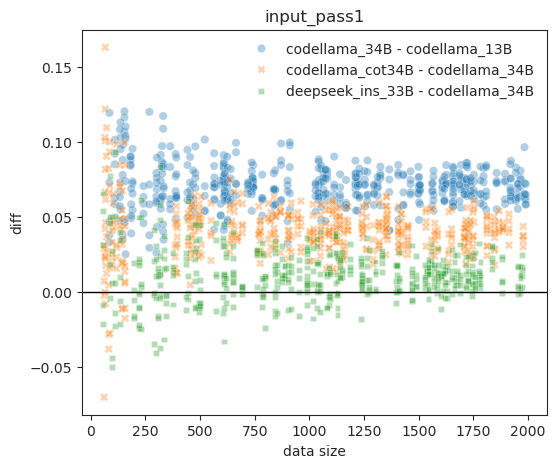

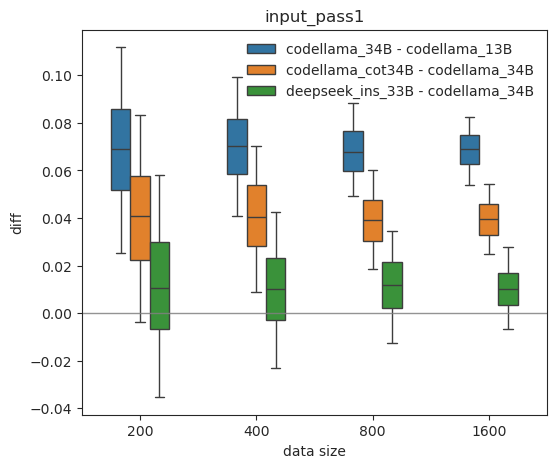

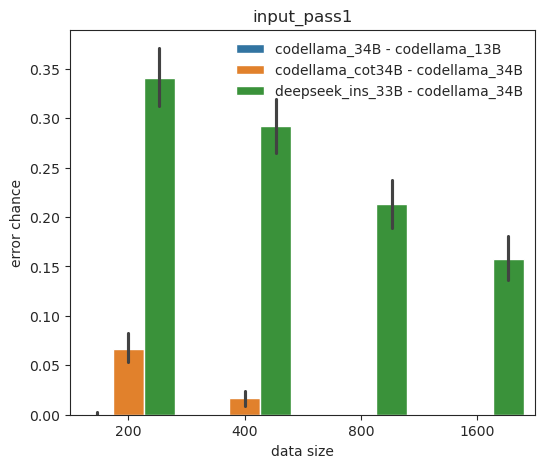

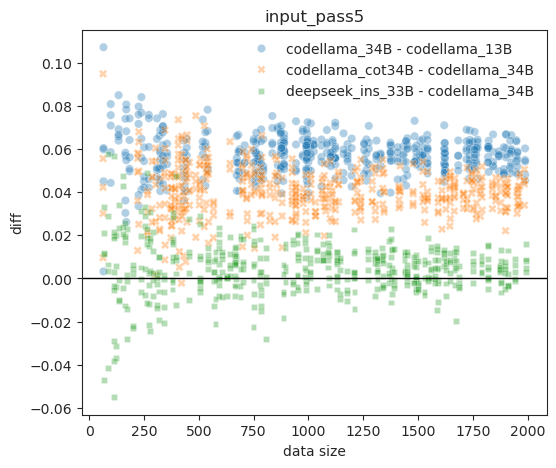

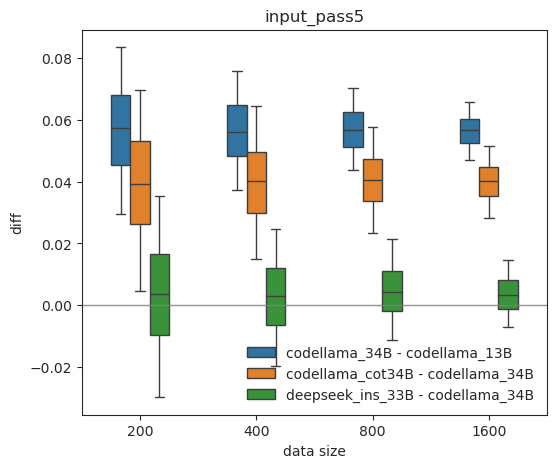

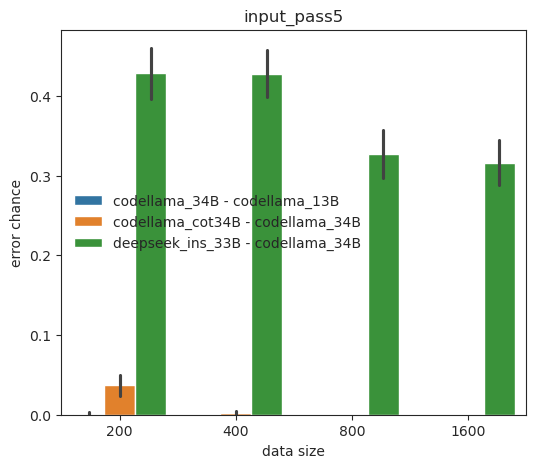

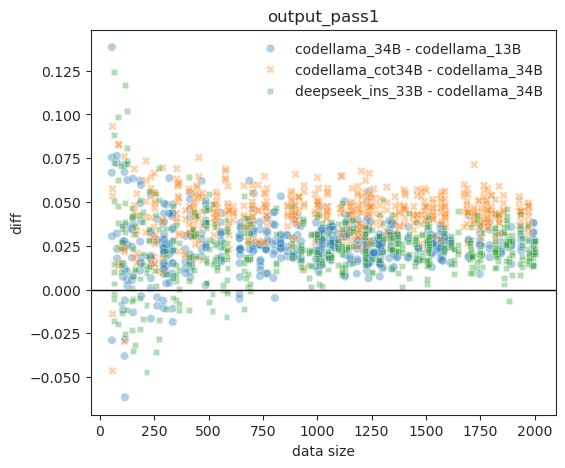

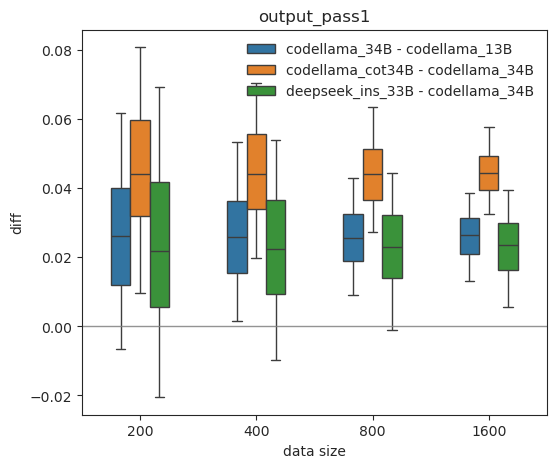

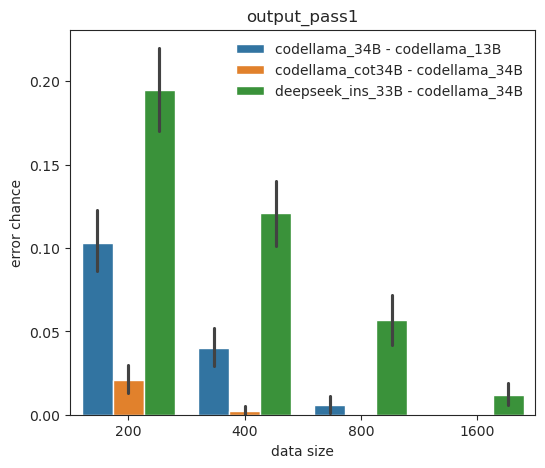

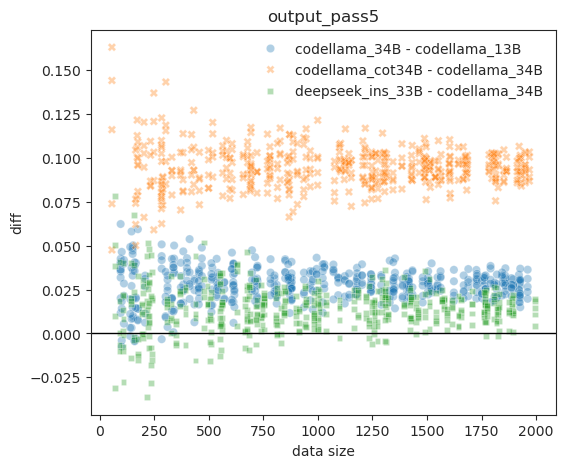

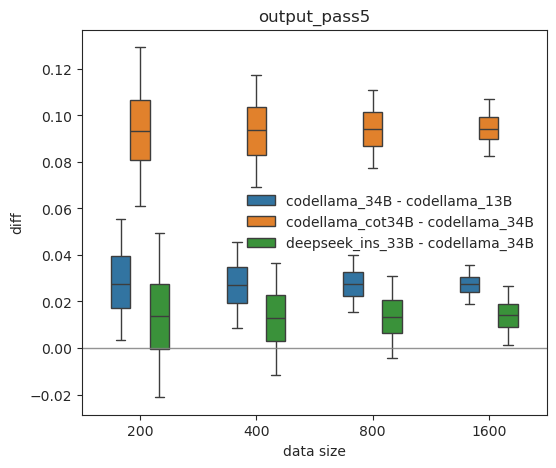

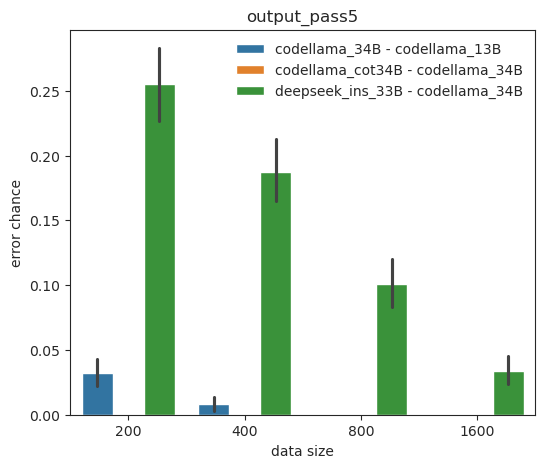

In [8]:
def plot_intervals(wrong_chance, wrong_chance_group, name):    
    os.makedirs('figs/wrong_order/', exist_ok=True)
    plt.figure(figsize=(6,5))
    ax = sns.scatterplot(wrong_chance, x='data size', y='diff', hue='type', style='type', alpha=0.35, sizes=2)
    ax.axhline(0, color='black', linewidth=1) 
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    display(wrong_chance)
    leg = plt.legend(frameon=False)
    # To remove the legend title use: (empty string sets no title)
    leg.set_title('')
    plt.title(name)
    plt.savefig(f'figs/wrong_order/wrong_order_scatter_{name}.pdf', bbox_inches = 'tight')

    plt.figure(figsize=(6,5))
    ax = sns.boxplot(data=wrong_chance_group, x='data size', y='diff', hue='type', whis=(5, 95), showfliers=False, width=0.5)
    # ax = sns.violinplot(data=wrong_chance_group, x='data size', y='diff', hue='type')
    ax.axhline(0, color='grey', linewidth=1, alpha=0.85) 
    leg = plt.legend(frameon=False)
    # To remove the legend title use: (empty string sets no title)
    leg.set_title('')
    plt.title(name)
    plt.savefig(f'figs/wrong_order/wrong_order_box_{name}.pdf',  bbox_inches = 'tight')

    wrong_chance_group['diff'] > 0
    wrong_chance_group['error chance'] = wrong_chance_group.apply(lambda x: 1 if x['diff'] < 0 else 0, axis=1)
    plt.figure(figsize=(6,5))
    ax = sns.barplot(data=wrong_chance_group, x='data size', y='error chance', hue='type')
    # ax.axhline(0, color='black', linewidth=1) 
    leg = plt.legend(frameon=False)
    # To remove the legend title use: (empty string sets no title)
    leg.set_title('')
    plt.title(name)
    plt.savefig(f'figs/wrong_order/wrong_order_chance_{name}.pdf',  bbox_inches = 'tight')


for task in ['input', 'output']:
    for passk in ['pass1', 'pass5']:
        wrong_chance, wrong_chance_group = get_intervals(df_wide, task=task, passk=passk, B=1000)
        plot_intervals(wrong_chance, wrong_chance_group, f'{task}_{passk}')



# for task in ['input', 'output']:
#     for passk in ['pass1']:
#         wrong_chance, wrong_chance_group = get_intervals(df_wide, task=task, passk=passk, B=100, resample=True)
#         plot_intervals(wrong_chance, wrong_chance_group, f'{task}_{passk}_resample')

# Generate the main result table by taking the first 800 samples


In [9]:
# final_set = execution_info[execution_info['is_bad'] == False][0:800]
# 
def convert():
    execution_info = pd.read_csv('execution_info.csv', index_col='num')
    # final_set = execution_info[execution_info['is_bad'] == False][0:800]
    # display(final_set)
    execution_info['is_main'] = False

    select = execution_info[execution_info['is_bad'] == False][0:800].index
    last = select[-1]
    execution_info['is_main'] = (execution_info.index <= last) & (execution_info['is_bad'] == False)
    print('any is main is_bad', any(execution_info[execution_info['is_main'] == True]['is_bad']))
    print('should be 800', len(execution_info[execution_info['is_main']]))
    execution_info.to_csv('execution_info_800.csv', index_label='num')
    return execution_info
# execution_info = convert()
# display(execution_info)
final_set = execution_info[execution_info['is_main'] == True]
display(final_set)
_merged = pd.merge(final_set, df_data, on='id', sort=False)
annotated_res_hat = pd.merge(_merged, df_result, on='id', sort=False)

,id,num_ins,bad,numsteps,is_bad,is_main
num,,,,,,
0,"973,11,4",14,Counter(),50.000,False,True
1,"1760,1,1",19,Counter(),47.000,False,True
2,"1536,21,3",14,Counter(),231.000,False,True
3,"805,14,3",18,Counter(),104.000,False,True
4,"587,30,0",14,Counter(),43.000,False,True
...,...,...,...,...,...,...
910,"87,16,3",16,Counter(),57.000,False,True
911,"757,14,3",26,Counter(),66.000,False,True
912,"1935,46,4",15,Counter(),81.000,False,True


In [10]:
def doresample(r, task):
    # print(r.index)
    for model in models_trans:
        n = r[('n', model, task)]
        c0 = r[('c', model, task)]
        p = c0 / n
        p_s = np.random.binomial(10, p) / 10
        r[('pass1', model, task)] = p_s
        # r[('pass5', model, task)] = pass_at_k(10, c, 5)
    # print(r)
    return r

def main_results_bars(df_wide, task = 'output', passk='pass1',  B=10000, resample=False):
    def boostrap_diff(n_data, B=10):
        samps = []
        for i in range(B):
            draw10 = df_wide.sample(n_data, replace=True)
            # draw10 = df_wide
            if resample:
                draw10 = draw10.apply(lambda x: doresample(x, task), axis=1)
            samps.append(draw10.aggregate('mean', axis=0))
            # samps.append(df_wide.sample(n_data, replace=True).aggregate('mean', axis=0))

        means = pd.concat(samps, axis=1).transpose()
        means = means[passk]
        # for m in models:
            # means[pair[0]][task] - means[pair[1]][task]
        filtered = sorted([c for c in means.columns if c[1] == task])
        df = means[filtered]
        df.columns = df.columns.droplevel(1)
        return df
    return boostrap_diff(len(df_wide), B=B)
    


In [11]:
def get_relations(df, task='output'):
    cols = df.columns
    taskcols = [c for c in cols if c[1] == task]
    df_task = pd.DataFrame({t[0]: df[t].values for t in taskcols}, index=df.index.values)
    # df_task.reset_index()
    df_task.index.name = 'id'
    df_task = df_task[sorted(df_task.columns)]
    return df_task

df_wide_hat = get_wide(annotated_res_hat)
# wrong_chance_hat, wrong_chance_group_hat = get_intervals(df_wide_hat)
# plot_intervals(wrong_chance_hat, wrong_chance_group_hat)
def std(p1):
    p = p1.values
    n = 10
    N = p.size
    total_var = np.sum(p * (1-p) / n)
    return np.sqrt(total_var) / N

def main_result_table(df_wide, name):
    series = {}
    for task in ['input', 'output']:
        for passk in ['pass1', 'pass5']:
            df_model_task = get_relations(df_wide[passk], task=task)
            # display(df_model_task)
            series[(task, passk, 'mean')] = df_model_task.agg('mean')

            main_bars = main_results_bars(df_wide, task=task, passk=passk, B=10000, resample=False)
            series[(task, passk, 'data_std')] = main_bars.agg('std')
            if passk == 'pass1':
                pass
                series[(task, 'pass1', 'samp_std')] = df_model_task.agg(std) 

        
    result_table = pd.DataFrame.from_dict(series)
    result_table.to_csv(f'{name}')
    return result_table

main_result_table(df_wide, 'main_results_2000.csv')
result_table = main_result_table(df_wide_hat, 'main_results.csv')
display(result_table) 

input                                  output           \
                 pass1                   pass5           pass1            
                  mean data_std samp_std  mean data_std   mean data_std   
codellama_13B    0.390    0.015    0.003 0.582    0.013  0.384    0.016   
codellama_34B    0.465    0.016    0.003 0.647    0.013  0.411    0.017   
codellama_7B     0.366    0.015    0.003 0.552    0.013  0.364    0.016   
codellama_cot13B 0.391    0.014    0.003 0.552    0.014  0.393    0.014   
codellama_cot34B 0.504    0.015    0.003 0.683    0.014  0.460    0.015   
codellama_py_13B 0.405    0.015    0.003 0.580    0.014  0.378    0.016   
codellama_py_34B 0.415    0.015    0.003 0.592    0.014  0.407    0.017   
codellama_py_7B  0.363    0.015    0.002 0.560    0.014  0.364    0.016   
deepseek_33B     0.466    0.016    0.002 0.651    0.014  0.436    0.017   
deepseek_7B      0.411    0.016    0.002 0.617    0.014  0.398    0.016   
deepseek_ins_33B 0.474    0.016    0.002 0.642    0.014  0.440    0.017   
deepseek_ins_7B  0.366    0.016    0.002 0.544    0.015  0.410    0.017   
gpt35            0.492    0.016    0.002 0.665    0.015  0.500    0.017   
gpt35_cot        0.491    0.013    0.004 0.763    0.013  0.633    0.014   
gpt4             0.671    0.016    0.001 0.768    0.014  0.634    0.017   
gpt4_cot         0.748    0.012    0.003 0.884    0.010  0.819    0.012   
mistral          0.360    0.015    0.002 0.542    0.014  0.317    0.015   
phi1             0.139    0.012    0.001 0.226    0.013  0.233    0.014   
phi1.5           0.241    0.014    0.002 0.389    0.013  0.271    0.015   
phind_34B        0.479    0.016    0.002 0.649    0.014  0.383    0.017   
starcoder_16B    0.316    0.015    0.002 0.495    0.014  0.333    0.016   
starcoder_7B     0.300    0.015    0.002 0.489    0.014  0.311    0.015   
wizard_13B       0.392    0.016    0.002 0.548    0.015  0.379    0.016   
wizard_34B       0.428    0.016    0.002 0.573    0.015  0.412    0.017   

                                          
                          pass5           
                 samp_std  mean data_std  
codellama_13B       0.002 0.532    0.015  
codellama_34B       0.002 0.561    0.015  
codellama_7B        0.002 0.496    0.015  
codellama_cot13B    0.003 0.599    0.015  
codellama_cot34B    0.003 0.653    0.015  
codellama_py_13B    0.002 0.508    0.015  
codellama_py_34B    0.002 0.537    0.015  
codellama_py_7B     0.002 0.497    0.015  
deepseek_33B        0.002 0.576    0.015  
deepseek_7B         0.002 0.539    0.015  
deepseek_ins_33B    0.002 0.580    0.015  
deepseek_ins_7B     0.002 0.525    0.016  
gpt35               0.001 0.601    0.016  
gpt35_cot           0.003 0.812    0.012  
gpt4                0.001 0.687    0.016  
gpt4_cot            0.002 0.907    0.009  
mistral             0.002 0.452    0.015  
phi1                0.002 0.340    0.015  
phi1.5              0.002 0.394    0.015  
phind_34B           0.001 0.492    0.016  
starcoder_16B       0.002 0.477    0.015  
starcoder_7B        0.002 0.438    0.015  
wizard_13B          0.002 0.516    0.015  
wizard_34B          0.001 0.522    0.016

Index(['phi1', 'phi1.5', 'starcoder_7B', 'mistral', 'starcoder_16B',
       'codellama_7B', 'codellama_py_7B', 'codellama_py_13B', 'wizard_13B',
       'phind_34B', 'codellama_13B', 'codellama_cot13B', 'deepseek_7B',
       'codellama_py_34B', 'deepseek_ins_7B', 'codellama_34B', 'wizard_34B',
       'deepseek_33B', 'deepseek_ins_33B', 'codellama_cot34B', 'gpt35',
       'gpt35_cot', 'gpt4', 'gpt4_cot'],
      dtype='object', name='model')

Index(['phi1', 'phi1.5', 'starcoder_7B', 'mistral', 'starcoder_16B',
       'phind_34B', 'codellama_7B', 'codellama_py_7B', 'codellama_py_13B',
       'wizard_13B', 'wizard_34B', 'deepseek_ins_7B', 'codellama_13B',
       'codellama_py_34B', 'deepseek_7B', 'codellama_34B', 'deepseek_33B',
       'deepseek_ins_33B', 'codellama_cot13B', 'gpt35', 'codellama_cot34B',
       'gpt4', 'gpt35_cot', 'gpt4_cot'],
      dtype='object', name='model')

Index(['phi1', 'phi1.5', 'starcoder_7B', 'starcoder_16B', 'mistral',
       'codellama_py_7B', 'deepseek_ins_7B', 'codellama_7B', 'codellama_13B',
       'codellama_cot13B', 'wizard_13B', 'codellama_py_13B', 'deepseek_7B',
       'codellama_py_34B', 'wizard_34B', 'codellama_34B', 'deepseek_33B',
       'deepseek_ins_33B', 'phind_34B', 'gpt35_cot', 'gpt35',
       'codellama_cot34B', 'gpt4', 'gpt4_cot'],
      dtype='object', name='model')

Index(['phi1', 'phi1.5', 'starcoder_7B', 'starcoder_16B', 'mistral',
       'deepseek_ins_7B', 'wizard_13B', 'codellama_7B', 'codellama_cot13B',
       'codellama_py_7B', 'wizard_34B', 'codellama_py_13B', 'codellama_13B',
       'codellama_py_34B', 'deepseek_7B', 'deepseek_ins_33B', 'codellama_34B',
       'phind_34B', 'deepseek_33B', 'gpt35', 'codellama_cot34B', 'gpt35_cot',
       'gpt4', 'gpt4_cot'],
      dtype='object', name='model')

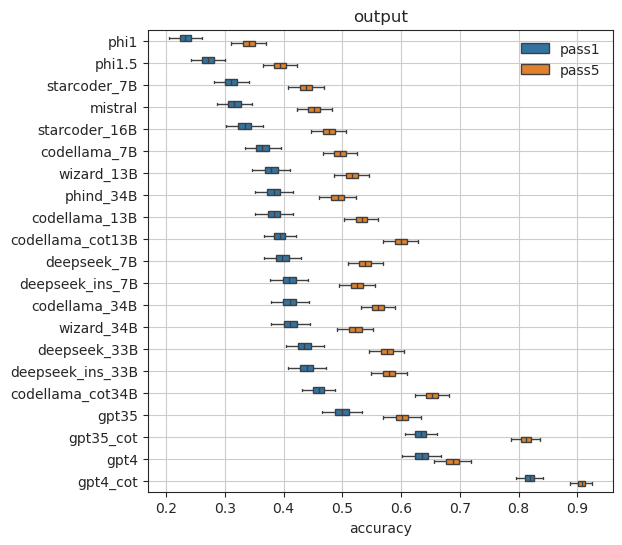

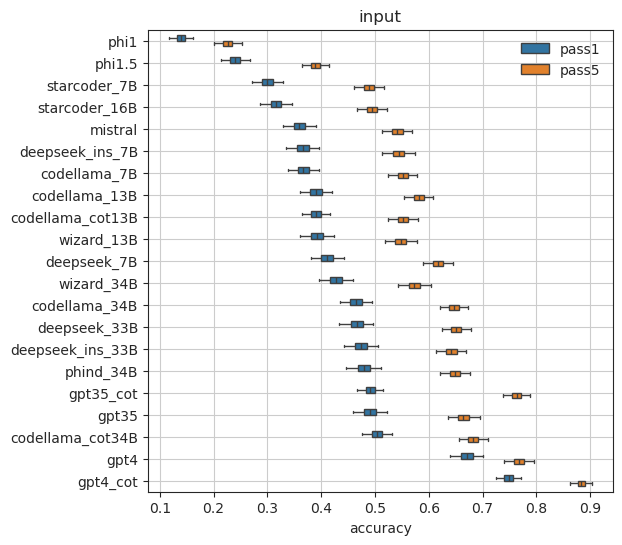

In [12]:
def baseline_plot(data, base=None, task=task, passk=None, suffix=''):
    main_bars = pd.DataFrame(data)
    if base is not None:
        mean = main_bars[base].mean()
        print(mean)
        # mean = 0
        for c in main_bars.columns:
            if c != base:
                main_bars[c] = main_bars[c] - main_bars[base] + mean
        main_bars[base] = mean

    means = main_bars.mean()
    means.sort_values(ascending=True, inplace=True)

    display(means.index)
    res = main_bars[means.index]
    res = res.drop([c for c in res.columns if '_py_' in c], axis=1)

    # display(res)

    res = res.reset_index()
    res = res.melt(id_vars='sample_id', value_vars=res.columns)
    res = res[['model', 'value']]
    res['passk'] = passk
    if base:
        res['baseline'] = base
    else:
        res['baseline'] = 'none'

    # display(res)
    return res

def main_barplot(res, name):
    plt.figure(figsize=(6, 6))
    sns.boxplot(data=res, y='model', x='value', hue='passk', showfliers=False, whis=(2.5, 97.5), width=0.5)
    # sns.stripplot(data=res, orient='h', color='skyblue', inner='quart')
    plt.grid(True)
    # plt.xticks(rotation=90, ha='right')

    plt.title(f'{name}')
    plt.xlabel("accuracy")
    plt.ylabel("")
    leg = plt.legend(frameon=False)
    plt.savefig(f'figs/main_results/main_box_{name}.pdf', bbox_inches='tight')

# display(annotated_res)
# df_wide_hat.describe()

if True:
    for task in ['output', 'input']:
    # for task in ['output']:
        res = []
        for passk in ['pass1', 'pass5']:
        # for passk in ['pass5']:
            main_bars = main_results_bars(df_wide_hat, task=task, passk=passk, B=10000)
            main_bars.index.name = 'sample_id'
            res.append(baseline_plot(main_bars, base=None, task=task, passk=passk))
            # res.append(baseline_plot(main_bars, base='codellama_34B', task=task, passk=passk))

        final = pd.concat(res)
        # display(final)
        main_barplot(final, f'{task}')

# for task in ['output']:
#     for passk in ['pass1', 'pass5']:
#         main_bars = main_results_bars(df_wide_hat, task=task, passk=passk, B=200, resample=True)
#         baseline_plot(main_bars, base=None, task=task, passk=passk, suffix='_samp')

# Scatter plots comparing various things

MultiIndex([( 'input', 'pass1',     'mean'),
            ( 'input', 'pass1', 'data_std'),
            ( 'input', 'pass1', 'samp_std'),
            ( 'input', 'pass5',     'mean'),
            ( 'input', 'pass5', 'data_std'),
            ('output', 'pass1',     'mean'),
            ('output', 'pass1', 'data_std'),
            ('output', 'pass1', 'samp_std'),
            ('output', 'pass5',     'mean'),
            ('output', 'pass5', 'data_std')],
           )

,display_name,model,size,family,cot,training,HumanEval@1,EvalPlus,MBPP@1,input_pass1,input_pass5,output_pass1,output_pass5
0,codellama_13B,codellama_13B,13.000,llama,False,base,0.360,0.370,NaN,0.390,0.582,0.384,0.532
1,codellama_34B,codellama_30B,34.000,llama,False,base,0.490,0.430,NaN,0.465,0.647,0.411,0.561
2,codellama_7B,codellama_7B,7.000,llama,False,base,0.340,0.340,NaN,0.366,0.552,0.364,0.496
3,codellama_cot13B,codellama_cot13B,13.000,llama,True,base,NaN,NaN,NaN,0.391,0.552,0.393,0.599
4,codellama_cot34B,codellama_cot30B,34.000,llama,True,base,NaN,NaN,NaN,0.504,0.683,0.460,0.653
8,gpt35,gpt35,99.000,gpt,False,instruct,0.760,0.640,NaN,0.492,0.665,0.500,0.601
9,gpt35_cot,gpt35_cot,99.000,gpt,True,instruct,NaN,NaN,NaN,0.491,0.763,0.633,0.812
10,gpt4,gpt4,99.000,gpt,False,instruct,0.840,0.770,NaN,0.671,0.768,0.634,0.687
11,gpt4_cot,gpt4_cot,99.000,gpt,True,instruct,NaN,NaN,NaN,0.748,0.884,0.819,0.907
12,mistral,mistral,7.000,other,False,base,0.310,0.230,0.48,0.360,0.542,0.317,0.452


/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x500 with 0 Axes>

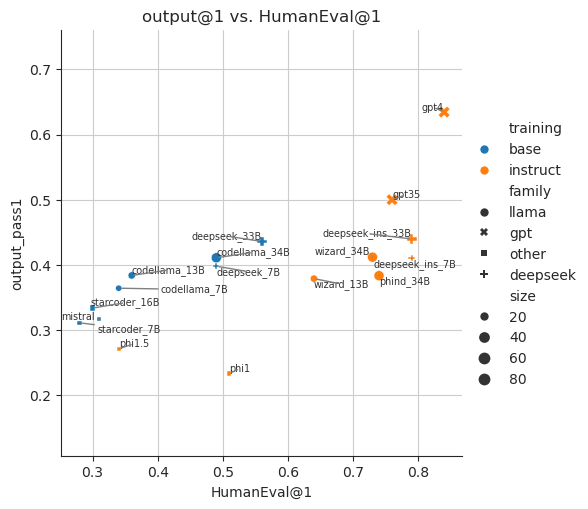

<Figure size 600x500 with 0 Axes>

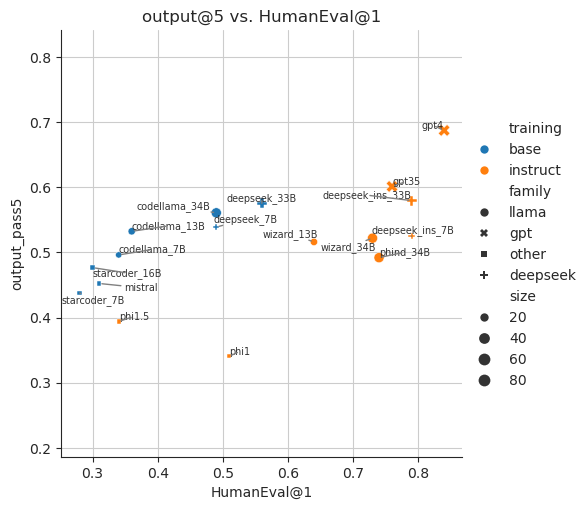

<Figure size 600x500 with 0 Axes>

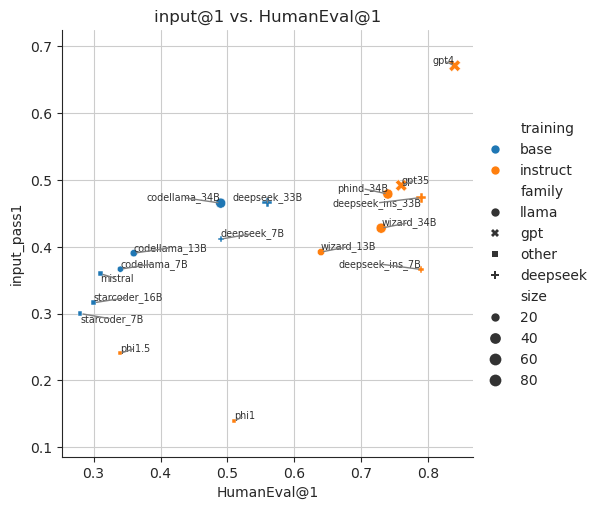

<Figure size 600x500 with 0 Axes>

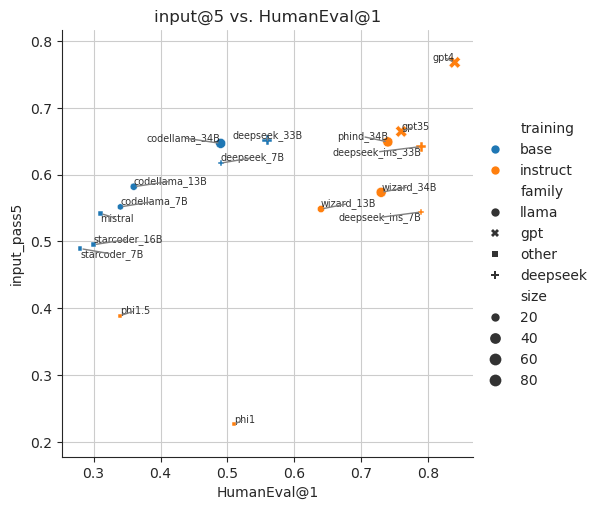

In [26]:
from adjustText import adjust_text

# display(result_table)
# display(df_info)
# print(result_table.index)
os.makedirs('figs/scatter/', exist_ok=True)
display(result_table.columns)
mean_cols = [r for r in result_table.columns if r[2] == 'mean'] 
result = pd.DataFrame(result_table[mean_cols])
result.columns = [f'{r[0]}_{r[1]}' for r in result.columns if r[2] == 'mean'] 
# display(result)
model_info = df_info.set_index('display_name')
data = model_info.merge(result, left_index = True, right_index = True)
data.index.name = 'display_name'
data = data.reset_index()
##########
data = data[data.apply(lambda x: not '_py_' in x['display_name'], axis=1)]
display(data)
# result_table.merge(df_info, left_on = 'index', right_on='display_name')

# ref EvalPlus | HumanEval@1
def humanevalvs(task='output', passk='pass1', ref='EvalPlus'):
    fig = plt.figure(figsize=(6, 5))
    data_he = data[data[ref]>0]
    sns.relplot(data=data_he, x=ref, y=f'{task}_{passk}', style='family', hue='training', size='size', size_norm=(5, 50))
    ax = plt.gca()
    ax.axis('equal')
    plt.grid(True)
    texts= []
    for i, point in data_he.iterrows():
        texts.append(plt.text(point[ref], point[f'{task}_{passk}'], str(point['display_name']), alpha=0.95, fontsize='x-small'))
    adjust_text(
        texts, 
        # min_arrow_len=2,
        expand_points=(1, 1),
        # arrowprops=dict(arrowstyle='-', color='gray', alpha=.5)
        arrowprops=dict(
            arrowstyle="-", 
            color='0.5', 
            lw=1
        )
    )
    name = f'{ref}_vs_{task}_{passk}'.replace('@', '_')
    fname = f'{task}@{passk[-1]} vs. {ref}' 
    plt.title(fname)
    # legend = plt.legend(title='My Legend')
    # legend.get_title().set_weight('bold')

    plt.savefig(f'figs/scatter/{name}.pdf',  bbox_inches = 'tight')

for ref in ['HumanEval@1']:
    humanevalvs('output', 'pass1', ref)
    humanevalvs('output', 'pass5', ref)
    humanevalvs('input', 'pass1', ref)
    humanevalvs('input', 'pass5', ref)


/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x500 with 0 Axes>

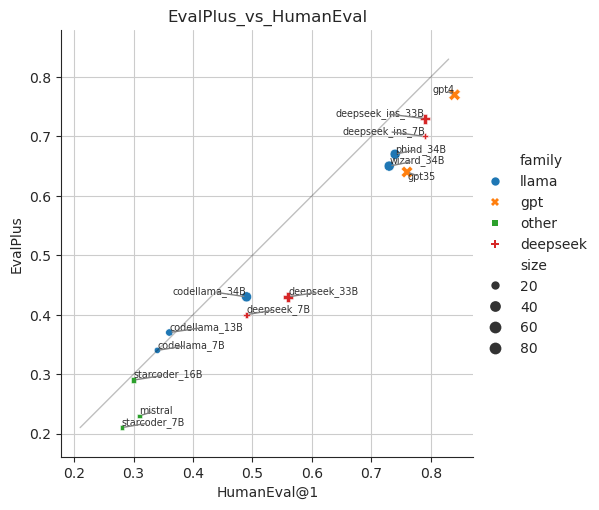

<Figure size 600x500 with 0 Axes>

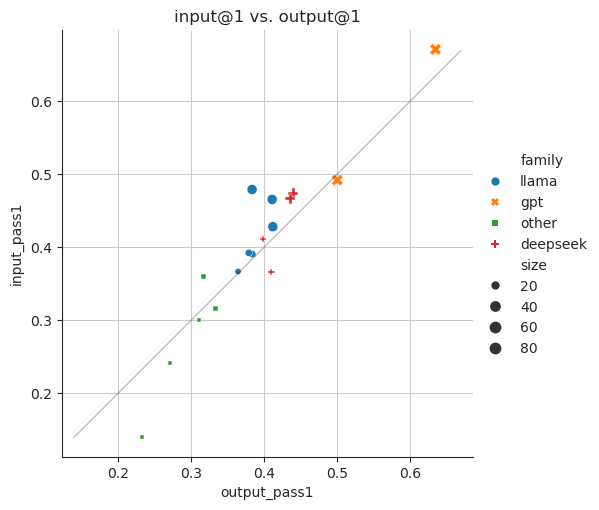

<Figure size 600x500 with 0 Axes>

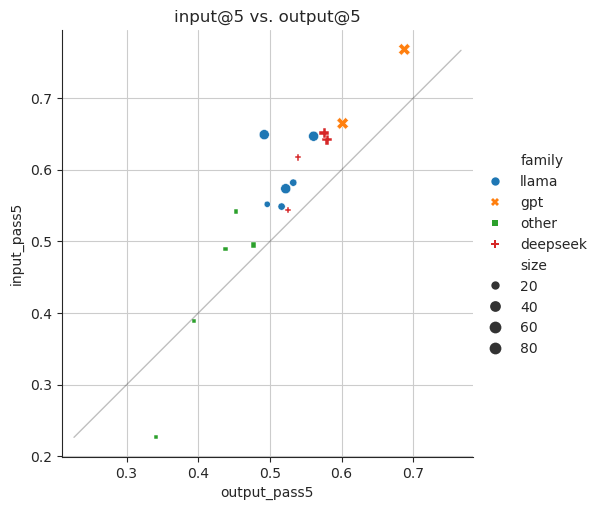

<Figure size 600x500 with 0 Axes>

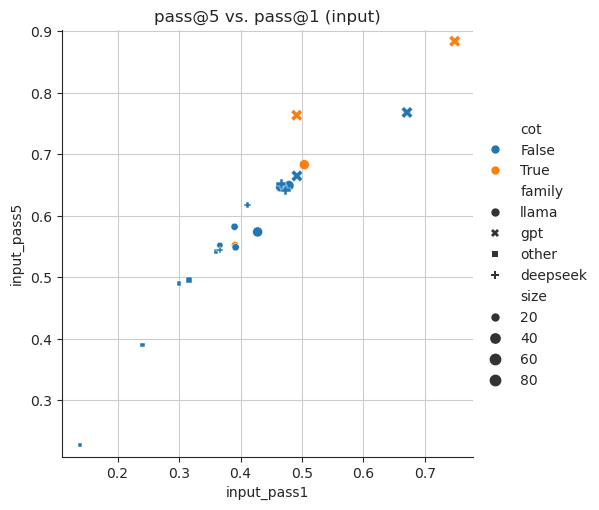

<Figure size 600x500 with 0 Axes>

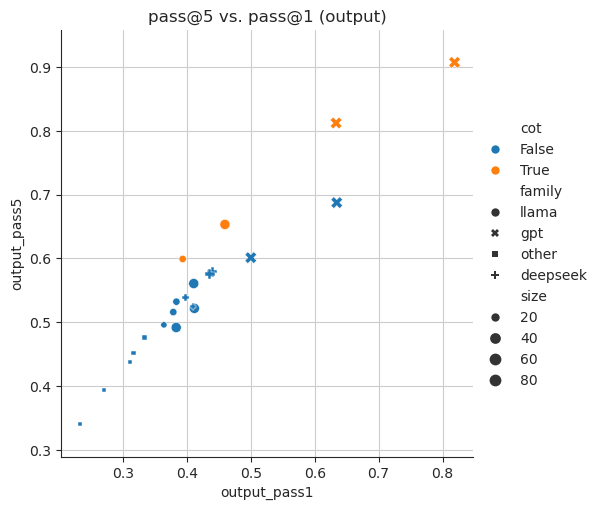

In [28]:
def main_results_yx(data, y, ref, hue='family', addtext=True, xyline=True):
    fig = plt.figure(figsize=(6, 5))
    data_he = data[(data[ref]>0) & (data[y]>0)]
    sns.relplot(data_he, x=ref, y=y, hue=hue, style='family', size='size', size_norm=(5, 50))
    ax = plt.gca()
    ax.axis('equal')
    plt.grid(True)

    if addtext:
        texts= []
        for i, point in data_he.iterrows():
            texts.append(plt.text(point[ref], point[y], str(point['display_name']), alpha=0.95, fontsize='x-small'))
        adjust_text(
            texts, 
            # min_arrow_len=2,
            expand_points=(1, 1),
            # arrowprops=dict(arrowstyle='-', color='gray', alpha=.5)
            arrowprops=dict(
                arrowstyle="-", 
                color='0.5', 
                lw=1
            )
        )
    
    if xyline:
        minx = data_he[ref].min()
        miny = data_he[y].min()
        maxx = data_he[ref].max()
        maxy = data_he[y].max()

        # print(minx, miny, maxx, maxy)
        mina = np.minimum(minx, miny)
        maxa = np.maximum(maxx, maxy)
        plt.plot(np.arange(mina, maxa, 0.01), np.arange(mina, maxa, 0.01), color='black', alpha=0.25, linewidth=1)

    

data_nocot = data[data.apply(lambda x: not '_cot' in x['display_name'], axis=1)]


main_results_yx(data_nocot, 'EvalPlus','HumanEval@1')
name = 'EvalPlus_vs_HumanEval'
plt.title(name)
plt.savefig(f'figs/scatter/{name}.pdf',  bbox_inches = 'tight')

# plt.figure(figsize=(6, 5))
main_results_yx(data_nocot, 'input_pass1','output_pass1', hue='family', addtext=False, xyline=True)
# sns.relplot(data, x='input_pass1', y='output_pass1', hue='family', style='cot', size='size', size_norm=(5, 50))
name = 'output@1_vs_input@1'.replace('@', '_')
plt.title('input@1 vs. output@1')
plt.savefig(f'figs/scatter/{name}.pdf',  bbox_inches = 'tight')


main_results_yx(data_nocot, 'input_pass5','output_pass5', hue='family', addtext=False, xyline=True)
# sns.relplot(data, x='input_pass5', y='output_pass5', hue='family', style='cot', size='size', size_norm=(5, 50))
name = 'input@5_vs_output@5'.replace('@', '_')
plt.title('input@5 vs. output@5')
plt.savefig(f'figs/scatter/{name}.pdf',  bbox_inches = 'tight')


main_results_yx(data,'input_pass5','input_pass1', addtext=False, hue='cot', xyline=False)
name = 'input_pass@5v1'.replace('@', '_')
plt.title("pass@5 vs. pass@1 (input)")
plt.savefig(f'figs/scatter/{name}.pdf',  bbox_inches = 'tight')


main_results_yx(data,'output_pass5','output_pass1', addtext=False, hue='cot', xyline=False)
name = 'output_pass@5v1'.replace('@', '_')
plt.title("pass@5 vs. pass@1 (output)")
plt.savefig(f'figs/scatter/{name}.pdf',  bbox_inches = 'tight')


# https://python-graph-gallery.com/web-text-repel-with-matplotlib/


,display_name,model,size,family,cot,training,HumanEval@1,EvalPlus,MBPP@1,input_pass1,input_pass5,output_pass1,output_pass5
0,codellama_13B,codellama_13B,13.000,llama,False,base,0.360,0.370,NaN,0.390,0.582,0.384,0.532
1,codellama_34B,codellama_30B,34.000,llama,False,base,0.490,0.430,NaN,0.465,0.647,0.411,0.561
3,codellama_cot13B,codellama_cot13B,13.000,llama,True,base,NaN,NaN,NaN,0.391,0.552,0.393,0.599
4,codellama_cot34B,codellama_cot30B,34.000,llama,True,base,NaN,NaN,NaN,0.504,0.683,0.460,0.653
8,gpt35,gpt35,99.000,gpt,False,instruct,0.760,0.640,NaN,0.492,0.665,0.500,0.601
9,gpt35_cot,gpt35_cot,99.000,gpt,True,instruct,NaN,NaN,NaN,0.491,0.763,0.633,0.812
10,gpt4,gpt4,99.000,gpt,False,instruct,0.840,0.770,NaN,0.671,0.768,0.634,0.687
11,gpt4_cot,gpt4_cot,99.000,gpt,True,instruct,NaN,NaN,NaN,0.748,0.884,0.819,0.907


/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/data/home/sida/miniconda/envs/cm3/lib/python3.9/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/data/hom

<Figure size 600x500 with 0 Axes>

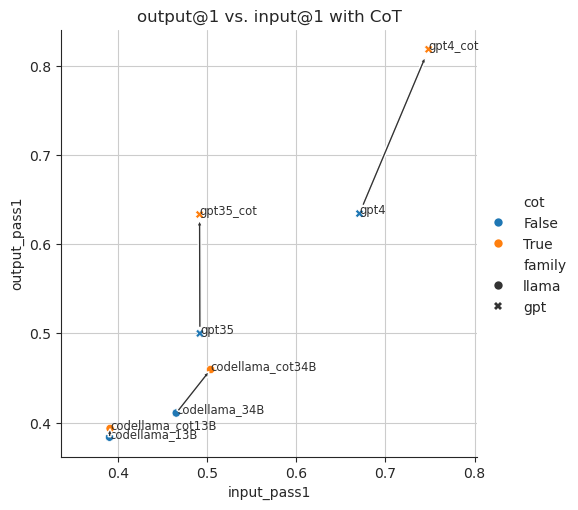

<Figure size 600x500 with 0 Axes>

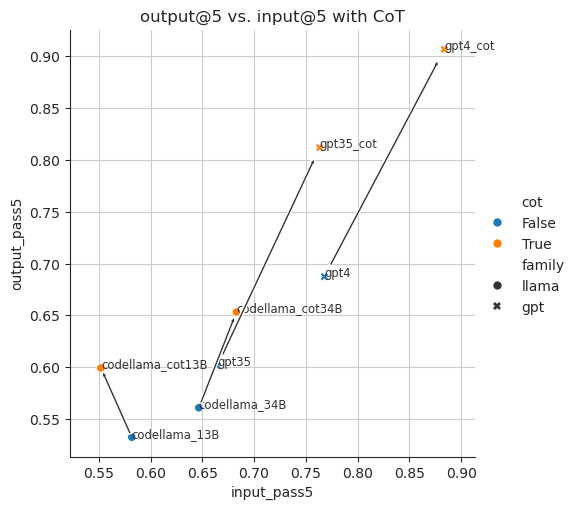

<Figure size 600x500 with 0 Axes>

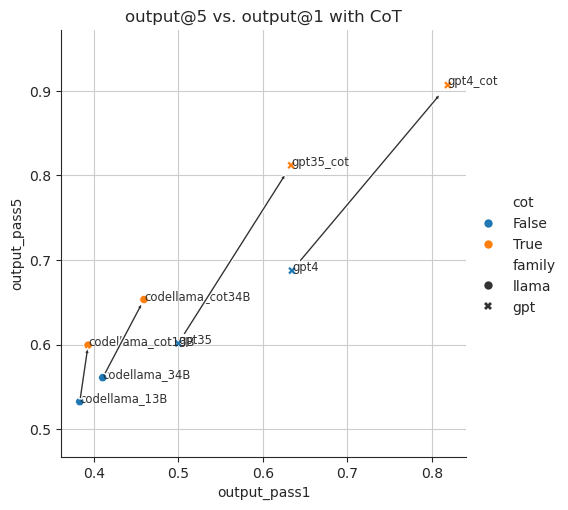

<Figure size 600x500 with 0 Axes>

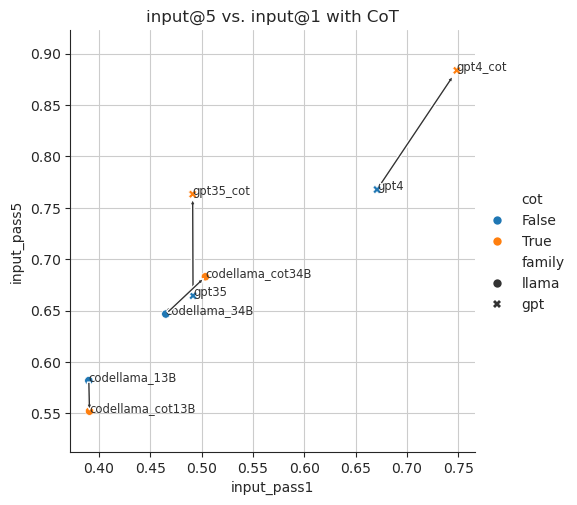

In [29]:

selected = ['gpt4', 'gpt4_cot', 'gpt35', 'gpt35_cot', 'codellama_13B', 'codellama_34B', 'codellama_cot13B', 'codellama_cot34B']
pairs = [('gpt4', 'gpt4_cot'),
         ('gpt35', 'gpt35_cot'),
         ('codellama_13B', 'codellama_cot13B'),
        ('codellama_34B', 'codellama_cot34B')]
data_cot = data[data['display_name'].isin(selected)]
display(data_cot)

def cot_plot(x='input_pass1', y='output_pass1'):
    plt.figure(figsize=(6, 5))
    
    sns.relplot(data_cot, x=x, y=y, hue='cot', style='family', size_norm=(5, 50))
    ax = plt.gca()
    ax.axis('equal')

    texts = []
    for i, point in data_cot.iterrows():
        texts.append(plt.text(point[x], point[y], str(point['display_name']), alpha=0.95, fontsize='small'))

    def getxy(name):
        r = data_cot[data_cot['display_name'] == name]
        return (r[x], r[y])
    for p in pairs:
        ax.annotate('', xy=getxy(p[1]), xytext=getxy(p[0]),
            arrowprops=dict(facecolor='0.2', shrink=0.05, width=2, headwidth=4, headlength=4),
            )


    plt.grid(True)
    def xname(x):
        t, p = x.split('_')
        return f'{t}@{p[-1]}'
    fname = f'{xname(y)} vs. {xname(x)} with CoT'
    plt.title(fname)
    name = f'cot_{x}_{y}'.replace('@', '_')
    plt.savefig(f'figs/scatter/{name}.pdf',  bbox_inches = 'tight')

cot_plot(x='input_pass1', y='output_pass1')
cot_plot(x='input_pass5', y='output_pass5')
cot_plot(x='output_pass1', y='output_pass5')
cot_plot(x='input_pass1', y='input_pass5')

,codellama_13B,codellama_34B,codellama_7B,codellama_cot13B,codellama_cot34B,codellama_py_13B,codellama_py_34B,codellama_py_7B,deepseek_33B,deepseek_7B,...,gpt4,gpt4_cot,mistral,phi1,phi1.5,phind_34B,starcoder_16B,starcoder_7B,wizard_13B,wizard_34B
id,,,,,,,,,,,,,,,,,,,,,
"1001,37,1",0.070,0.010,0.420,0.200,1.000,0.110,0.080,0.260,0.290,0.290,...,0.300,0.800,0.700,0.000,0.050,1.000,0.120,0.260,0.750,0.340
"1004,11,3",0.000,0.000,0.000,0.000,0.200,0.000,0.000,0.000,0.000,0.000,...,0.000,0.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"1004,27,1",0.000,0.960,0.000,0.000,0.000,0.000,0.200,0.000,1.000,0.000,...,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
"1005,10,2",0.780,1.000,0.960,1.000,1.000,0.170,1.000,1.000,1.000,0.480,...,1.000,1.000,0.770,0.000,0.540,1.000,0.000,0.290,0.000,1.000
"1007,22,3",0.510,0.370,0.510,0.200,0.000,0.520,0.160,0.420,0.600,0.170,...,0.600,1.000,0.600,0.000,0.800,0.000,0.000,0.000,0.880,0.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"990,3,2",1.000,1.000,1.000,0.900,1.000,1.000,1.000,1.000,1.000,0.870,...,1.000,1.000,1.000,0.000,0.610,1.000,0.810,1.000,0.670,1.000
"991,17,2",0.000,0.010,0.010,0.200,0.600,0.000,0.000,0.000,0.000,0.000,...,0.200,0.300,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"992,6,2",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


,phi1,phi1.5,starcoder_7B,starcoder_16B,mistral,wizard_13B,wizard_34B,phind_34B,codellama_7B,codellama_13B,...,codellama_cot13B,codellama_cot34B,deepseek_7B,deepseek_ins_7B,deepseek_33B,deepseek_ins_33B,gpt35,gpt4,gpt4_cot,gpt35_cot
phi1,1.000,0.426,0.378,0.357,0.305,0.319,0.334,0.229,0.311,0.301,...,0.210,0.248,0.254,0.278,0.186,0.191,0.219,0.168,0.209,0.266
phi1.5,0.426,1.000,0.460,0.473,0.415,0.318,0.263,0.267,0.440,0.393,...,0.316,0.272,0.396,0.355,0.280,0.224,0.321,0.164,0.187,0.255
starcoder_7B,0.378,0.460,1.000,0.716,0.654,0.543,0.444,0.437,0.683,0.652,...,0.445,0.443,0.597,0.540,0.500,0.410,0.365,0.233,0.271,0.362
starcoder_16B,0.357,0.473,0.716,1.000,0.653,0.531,0.435,0.416,0.700,0.653,...,0.423,0.427,0.607,0.544,0.503,0.429,0.346,0.259,0.291,0.358
mistral,0.305,0.415,0.654,0.653,1.000,0.503,0.440,0.432,0.668,0.655,...,0.474,0.477,0.646,0.554,0.506,0.441,0.396,0.287,0.346,0.416
wizard_13B,0.319,0.318,0.543,0.531,0.503,1.000,0.589,0.559,0.597,0.690,...,0.546,0.493,0.546,0.548,0.583,0.570,0.396,0.350,0.410,0.486
wizard_34B,0.334,0.263,0.444,0.435,0.440,0.589,1.000,0.641,0.502,0.590,...,0.503,0.505,0.468,0.525,0.538,0.548,0.375,0.408,0.446,0.517
phind_34B,0.229,0.267,0.437,0.416,0.432,0.559,0.641,1.000,0.522,0.579,...,0.522,0.617,0.531,0.538,0.591,0.568,0.426,0.444,0.439,0.529
codellama_7B,0.311,0.440,0.683,0.700,0.668,0.597,0.502,0.522,1.000,0.730,...,0.555,0.501,0.678,0.572,0.590,0.495,0.420,0.290,0.332,0.430
codellama_13B,0.301,0.393,0.652,0.653,0.655,0.690,0.590,0.579,0.730,1.000,...,0.576,0.551,0.689,0.616,0.665,0.576,0.441,0.363,0.397,0.487


,phi1,phi1.5,starcoder_7B,starcoder_16B,mistral,wizard_13B,wizard_34B,phind_34B,codellama_7B,codellama_13B,...,codellama_cot13B,codellama_cot34B,deepseek_7B,deepseek_ins_7B,deepseek_33B,deepseek_ins_33B,gpt35,gpt4,gpt4_cot,gpt35_cot
phi1,1.000,0.332,0.336,0.285,0.264,0.286,0.304,0.238,0.257,0.253,...,0.199,0.233,0.224,0.259,0.172,0.177,0.224,0.174,0.226,0.243
phi1.5,0.332,1.000,0.394,0.386,0.350,0.270,0.238,0.259,0.362,0.318,...,0.270,0.252,0.324,0.285,0.218,0.192,0.272,0.155,0.193,0.208
starcoder_7B,0.336,0.394,1.000,0.604,0.557,0.448,0.381,0.390,0.559,0.535,...,0.368,0.380,0.523,0.463,0.418,0.355,0.306,0.215,0.268,0.290
starcoder_16B,0.285,0.386,0.604,1.000,0.551,0.439,0.361,0.375,0.583,0.540,...,0.344,0.356,0.540,0.463,0.442,0.380,0.302,0.238,0.257,0.291
mistral,0.264,0.350,0.557,0.551,1.000,0.430,0.384,0.391,0.570,0.541,...,0.394,0.396,0.547,0.478,0.415,0.372,0.330,0.268,0.304,0.333
wizard_13B,0.286,0.270,0.448,0.439,0.430,1.000,0.518,0.497,0.498,0.596,...,0.437,0.409,0.480,0.478,0.494,0.501,0.355,0.324,0.374,0.389
wizard_34B,0.304,0.238,0.381,0.361,0.384,0.518,1.000,0.568,0.429,0.506,...,0.433,0.429,0.427,0.457,0.486,0.487,0.348,0.374,0.413,0.431
phind_34B,0.238,0.259,0.390,0.375,0.391,0.497,0.568,1.000,0.455,0.500,...,0.451,0.522,0.491,0.480,0.522,0.516,0.382,0.411,0.403,0.439
codellama_7B,0.257,0.362,0.559,0.583,0.570,0.498,0.429,0.455,1.000,0.604,...,0.451,0.415,0.578,0.482,0.489,0.423,0.371,0.283,0.293,0.340
codellama_13B,0.253,0.318,0.535,0.540,0.541,0.596,0.506,0.500,0.604,1.000,...,0.473,0.451,0.592,0.511,0.573,0.516,0.394,0.330,0.365,0.398


,phi1,phi1.5,starcoder_7B,starcoder_16B,mistral,wizard_13B,wizard_34B,phind_34B,codellama_7B,codellama_13B,...,codellama_cot13B,codellama_cot34B,deepseek_7B,deepseek_ins_7B,deepseek_33B,deepseek_ins_33B,gpt35,gpt4,gpt4_cot,gpt35_cot
phi1,1.000,0.376,0.381,0.324,0.302,0.322,0.342,0.267,0.305,0.299,...,0.234,0.273,0.256,0.290,0.198,0.201,0.248,0.187,0.262,0.294
phi1.5,0.376,1.000,0.466,0.459,0.419,0.323,0.283,0.307,0.449,0.396,...,0.334,0.311,0.391,0.338,0.268,0.232,0.315,0.178,0.235,0.264
starcoder_7B,0.381,0.466,1.000,0.705,0.654,0.532,0.448,0.461,0.670,0.644,...,0.450,0.463,0.619,0.543,0.497,0.422,0.356,0.247,0.327,0.368
starcoder_16B,0.324,0.459,0.705,1.000,0.654,0.519,0.426,0.447,0.697,0.657,...,0.427,0.441,0.636,0.547,0.533,0.456,0.355,0.272,0.312,0.371
mistral,0.302,0.419,0.654,0.654,1.000,0.511,0.456,0.466,0.691,0.661,...,0.485,0.489,0.654,0.565,0.501,0.449,0.387,0.309,0.371,0.427
wizard_13B,0.322,0.323,0.532,0.519,0.511,1.000,0.602,0.579,0.604,0.717,...,0.539,0.501,0.569,0.556,0.592,0.588,0.415,0.364,0.451,0.488
wizard_34B,0.342,0.283,0.448,0.426,0.456,0.602,1.000,0.656,0.525,0.617,...,0.528,0.520,0.508,0.528,0.576,0.574,0.401,0.421,0.497,0.542
phind_34B,0.267,0.307,0.461,0.447,0.466,0.579,0.656,1.000,0.557,0.615,...,0.553,0.631,0.581,0.554,0.624,0.604,0.442,0.467,0.486,0.541
codellama_7B,0.305,0.449,0.670,0.697,0.691,0.604,0.525,0.557,1.000,0.738,...,0.571,0.525,0.698,0.586,0.604,0.520,0.450,0.337,0.365,0.449
codellama_13B,0.299,0.396,0.644,0.657,0.661,0.717,0.617,0.615,0.738,1.000,...,0.600,0.574,0.717,0.620,0.702,0.630,0.476,0.394,0.461,0.524


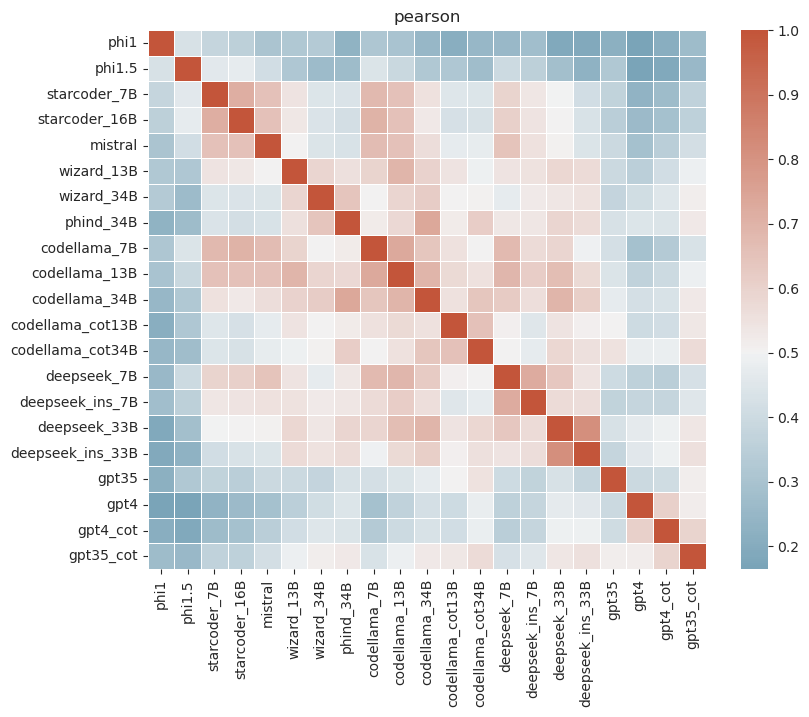

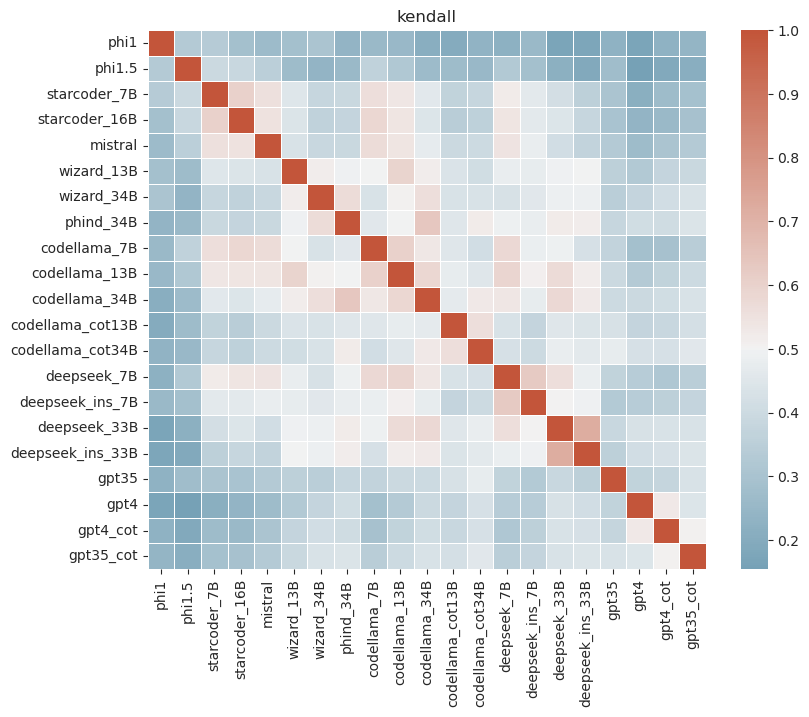

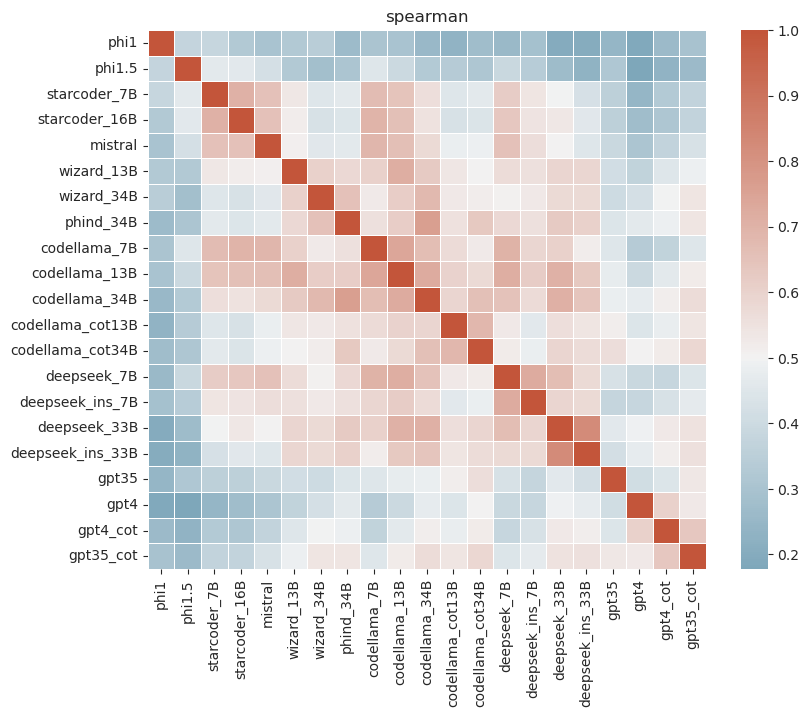

In [16]:

df_model_task = get_relations(df_wide_hat['pass1'], task='output')
df_model_task.to_csv('pass1_output_wide.csv')
df_model_task = get_relations(df_wide_hat['pass1'], task='input')
df_model_task.to_csv('pass1_input_wide.csv')

rearrange = [
    'phi1', 'phi1.5', 'starcoder_7B', 'starcoder_16B',  'mistral',
     'wizard_13B', 'wizard_34B', 'phind_34B', 
    'codellama_7B', 'codellama_13B', 'codellama_34B', 'codellama_cot13B', 'codellama_cot34B',
    'deepseek_7B', 'deepseek_ins_7B', 'deepseek_33B', 'deepseek_ins_33B', 
    'gpt35', 'gpt4', 'gpt4_cot', 'gpt35_cot', 
       ]

data = df_model_task
display(df_model_task)
data = data[rearrange]

def correlation_plot(method='pearson'):
    corr = (data).corr(method=method)
    display(corr)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(9, 7))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=1, center=0.5,
                square=False, linewidths=.5, annot=False)
    name = method
    plt.title(name)
    plt.savefig(f'figs/error_corr_{method}.pdf', bbox_inches = 'tight')

correlation_plot('pearson')
correlation_plot('kendall')
correlation_plot('spearman')


(21, 1752)
Index(['phi1', 'phi1.5', 'starcoder_7B', 'starcoder_16B', 'mistral',
       'wizard_13B', 'wizard_34B', 'phind_34B', 'codellama_7B',
       'codellama_13B', 'codellama_34B', 'codellama_cot13B',
       'codellama_cot34B', 'deepseek_7B', 'deepseek_ins_7B', 'deepseek_33B',
       'deepseek_ins_33B', 'gpt35', 'gpt4', 'gpt4_cot', 'gpt35_cot'],
      dtype='object')
(21, 1752)
Index(['phi1', 'phi1.5', 'starcoder_7B', 'starcoder_16B', 'mistral',
       'wizard_13B', 'wizard_34B', 'phind_34B', 'codellama_7B',
       'codellama_13B', 'codellama_34B', 'codellama_cot13B',
       'codellama_cot34B', 'deepseek_7B', 'deepseek_ins_7B', 'deepseek_33B',
       'deepseek_ins_33B', 'gpt35', 'gpt4', 'gpt4_cot', 'gpt35_cot'],
      dtype='object')
(21, 1752)
Index(['phi1', 'phi1.5', 'starcoder_7B', 'starcoder_16B', 'mistral',
       'wizard_13B', 'wizard_34B', 'phind_34B', 'codellama_7B',
       'codellama_13B', 'codellama_34B', 'codellama_cot13B',
       'codellama_cot34B', 'deepseek_7B', 'deep

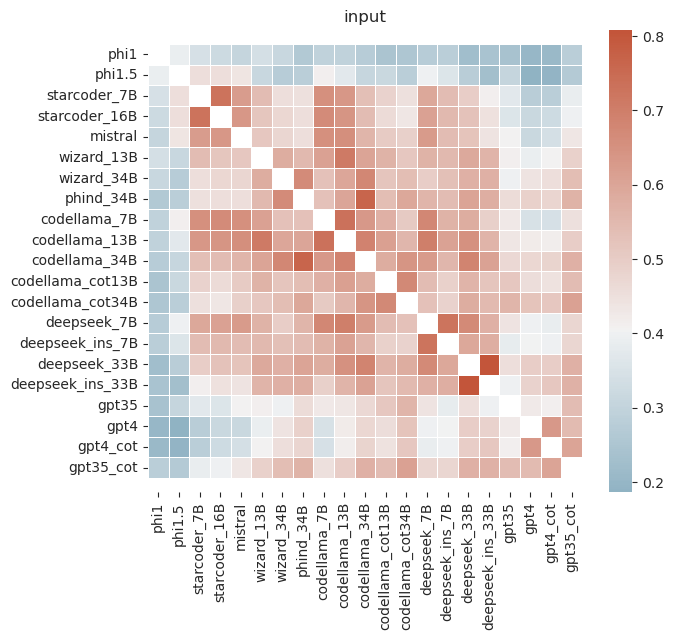

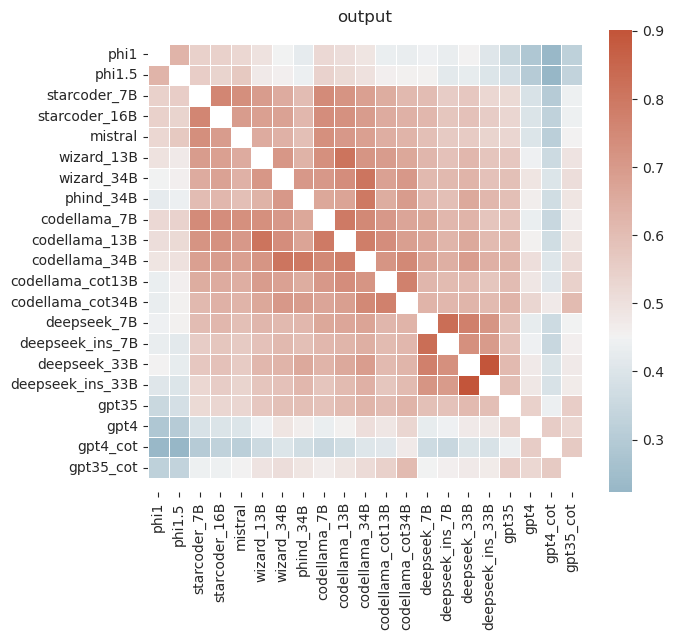

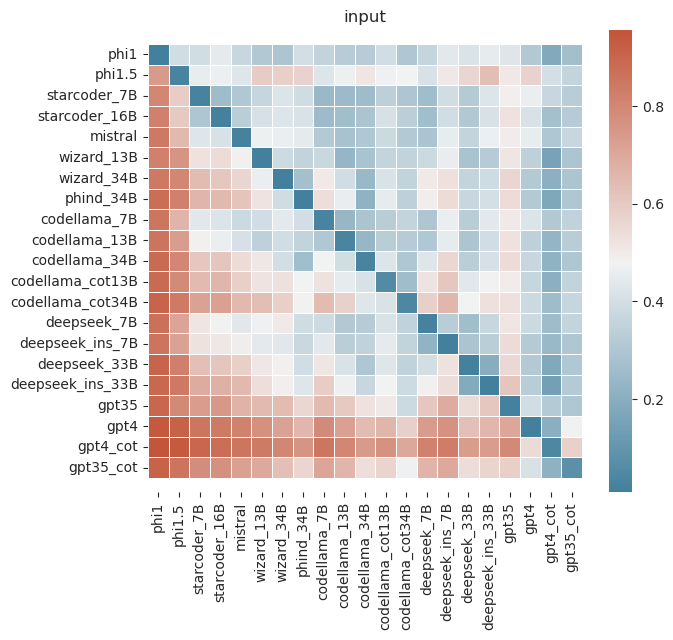

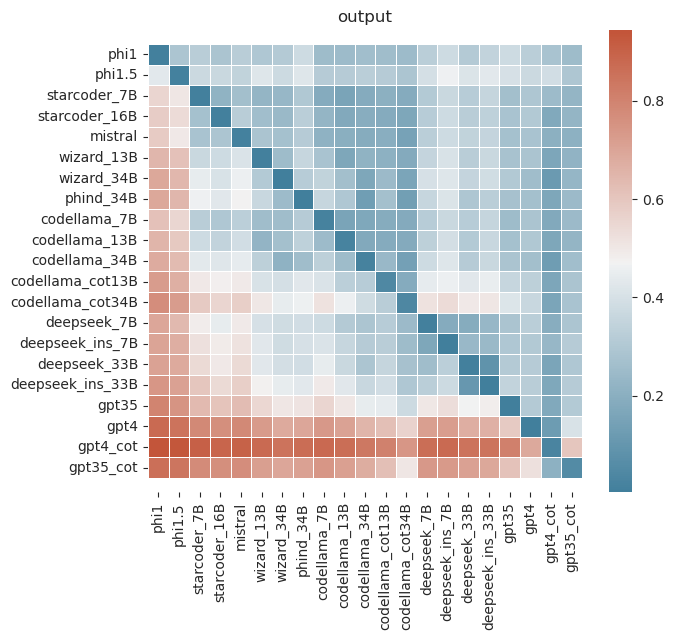

In [17]:

from scipy.spatial.distance import cdist
rearrange = [
    'phi1', 'phi1.5', 'starcoder_7B', 'starcoder_16B',  'mistral',
     'wizard_13B', 'wizard_34B', 'phind_34B', 
    'codellama_7B', 'codellama_13B', 'codellama_34B', 'codellama_cot13B', 'codellama_cot34B',
    'deepseek_7B', 'deepseek_ins_7B', 'deepseek_33B', 'deepseek_ins_33B', 
    'gpt35', 'gpt4', 'gpt4_cot', 'gpt35_cot', 
       ]
df_output = get_relations(df_wide['pass1'], task='output')[rearrange]
df_input = get_relations(df_wide['pass1'], task='input')[rearrange]
def getX(data):
    ms = data.columns
    X = np.zeros((len(ms), len(data)))
    for i, m1 in enumerate(data.columns):
        X[i, :] = data[m1].values
    return X

Xout = getX(df_output)
Xin = getX(df_input)
X = np.hstack((Xout, Xin))
X = Xin

def corplot(X, name, metric, prob=False):
    print(X.shape)
    def prob(y, x):
        return np.mean(y[x < 0.1]) / np.mean(y)

    if metric == 'correlation':
        metric = 'correlation'
        dist = 1 - cdist(X, X, metric=metric)
        for i in range(dist.shape[0]):
            dist[i, i] = float('-inf')
        max = np.max(dist.flatten())
        for i in range(dist.shape[0]):
            dist[i, i] = float('nan')
    else:
        dist = cdist(X, X, metric=prob)
        max = np.max(dist.flatten())
    
    ms = df_output.columns
    print(ms)

    corr = pd.DataFrame(dist, columns=ms, index=ms)
    # hinton_test(corr)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    plt.figure(figsize=(7, 6))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=max, center=max/2,
                    square=False, linewidths=.5, annot=False)
    ax = plt.gca()
    ax.axis('equal')
    plt.title(name)
    plt.savefig(f'figs/error_{metric}_{name}_heatmap.pdf', bbox_inches = 'tight')

corplot(Xin, 'input', metric='correlation')
corplot(Xout, 'output', metric='correlation')

corplot(Xin, 'input', metric='prob')
corplot(Xout, 'output', metric='prob')

def hinton_test(corr):
    corr_mat = corr.stack().reset_index(name="correlation")

    # Draw each cell as a scatter point with varying size and color
    g = sns.relplot(
        data=corr_mat,
        x="level_0", y="level_1", hue="correlation", size="correlation",
        palette="vlag", hue_norm=(0, max),
        height=7, sizes=(0, 250), size_norm=(0, max), cmap=cmap
    )

    # Tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
# plt.savefig(f'figs/error_corr_relplot.pdf', bbox_inches = 'tight')


,id,num_ins,bad,numsteps,is_bad,is_main,input,method,code,code_challenge,...,code_len,method_type,pass1,pass5,task,model,t,n,c,generations
0,"973,11,4",14,Counter(),50.000,False,True,"'.,,,,,. منبت'",str.istitle,def f(item):\n modified = item.replace('. '...,def f(item):\n modified = item.replace('. '...,...,163,str,0.040,0.188,input,deepseek_7B,0.800,100,4.000,"[f("",,,,, حاضر منتجات؟""), f('.,,,,,, منبت'), f..."
1,"973,11,4",14,Counter(),50.000,False,True,"'.,,,,,. منبت'",str.istitle,def f(item):\n modified = item.replace('. '...,def f(item):\n modified = item.replace('. '...,...,163,str,0.000,0.000,output,deepseek_7B,0.800,100,0.000,"['.,,,,,. منبت', '؟ منبت', '.,,,,,. منبت', 'من..."
2,"973,11,4",14,Counter(),50.000,False,True,"'.,,,,,. منبت'",str.istitle,def f(item):\n modified = item.replace('. '...,def f(item):\n modified = item.replace('. '...,...,163,str,0.200,0.778,input,codellama_cot34B,0.800,10,2.000,"[f(""...... فارغ""), f('.,,,,, منبت'.lower()), f..."
3,"973,11,4",14,Counter(),50.000,False,True,"'.,,,,,. منبت'",str.istitle,def f(item):\n modified = item.replace('. '...,def f(item):\n modified = item.replace('. '...,...,163,str,0.000,0.000,output,codellama_cot34B,0.800,10,0.000,"['! منبت', '?!منبت', ""! منبت? ."", '? , ? , ? ,..."
4,"973,11,4",14,Counter(),50.000,False,True,"'.,,,,,. منبت'",str.istitle,def f(item):\n modified = item.replace('. '...,def f(item):\n modified = item.replace('. '...,...,163,str,0.020,0.098,input,starcoder_7B,0.800,100,2.000,"[f(""منبت""), f(""منبت""), f(""منبت""), f(""منبت""), f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,"1450,49,3",16,Counter(),118.000,False,False,'',dict.clear,def f(text):\n d = {i:text.count(i) for i i...,def f(text):\n d = {i:text.count(i) for i i...,...,173,dict,1.000,1.000,output,codellama_13B,0.200,100,100.000,"[{'not_initial': 0}, {'not_initial': 0}, {'not..."
199996,"1450,49,3",16,Counter(),118.000,False,False,'',dict.clear,def f(text):\n d = {i:text.count(i) for i i...,def f(text):\n d = {i:text.count(i) for i i...,...,173,dict,0.090,0.382,input,codellama_py_7B,0.200,100,9.000,"[f(""banana""), f(""not_initial""), f(""hello""), f(..."
199997,"1450,49,3",16,Counter(),118.000,False,False,'',dict.clear,def f(text):\n d = {i:text.count(i) for i i...,def f(text):\n d = {i:text.count(i) for i i...,...,173,dict,1.000,1.000,output,codellama_py_7B,0.200,100,100.000,"[{'not_initial': 0}, {'not_initial': 0}, {'not..."
199998,"1450,49,3",16,Counter(),118.000,False,False,'',dict.clear,def f(text):\n d = {i:text.count(i) for i i...,def f(text):\n d = {i:text.count(i) for i i...,...,173,dict,0.000,0.000,input,phi1,0.200,100,0.000,"[f(""Hello, world!""), f(""Hello, world!""), f(""He..."


,id,num_ins,bad,numsteps,is_bad,is_main,input,method,code,code_challenge,...,code_len,method_type,pass1,pass5,task,model,t,n,c,generations
step_bins,,,,,,,,,,,,,,,,,,,,,
"(22.999, 34.0]",2856,2856,2856,2856,2856,2856,2856,2856,2856,2856,...,2856,2856,2856,2856,2856,2856,2856,2856,2856,2856
"(34.0, 49.0]",2460,2460,2460,2460,2460,2460,2460,2460,2460,2460,...,2460,2460,2460,2460,2460,2460,2460,2460,2460,2460
"(49.0, 94.0]",2598,2598,2598,2598,2598,2598,2598,2598,2598,2598,...,2598,2598,2598,2598,2598,2598,2598,2598,2598,2598
"(94.0, 3175.0]",2598,2598,2598,2598,2598,2598,2598,2598,2598,2598,...,2598,2598,2598,2598,2598,2598,2598,2598,2598,2598


/tmp/ipykernel_1183913/2170759220.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


<Axes: xlabel='pass1', ylabel='Count'>

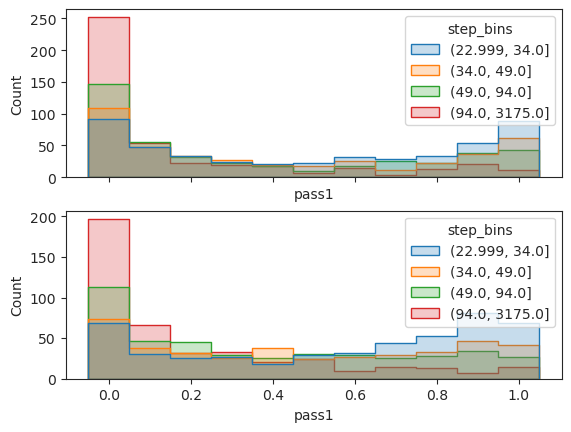

In [18]:
df = pd.DataFrame(annotated_res)
display(df)
task = 'output'
# selected = ['gpt4', 'gpt35', 'codellama_cot34B', 'gpt4_cot', 'gpt35_cot']
plt.figure()
selected = ['codellama_34B']
selected = ['gpt4', 'gpt4_cot', 'gpt35', 'gpt35_cot', 'codellama_34B', 'codellama_cot34B']
# df['<100'] = df['numsteps'] < 100
df= df[(df['task'] == task) & (df['model'].isin(selected)) & (df['t'] == 0.8) & (df['is_bad'] == False)]
df['step_bins'] = pd.cut(df['numsteps'], bins=[0, 50, 200, 2000])
df['step_bins'] = pd.qcut(df['numsteps'], q=4)
display(df.groupby('step_bins').agg('count'))
df = df.sort_values(by='model')

sns.violinplot(data=df, x = 'step_bins', y='pass1', hue='model', inner='stick',cut=0, split=True)
# sns.boxenplot(data=df, x = 'step_bins', y='pass1', hue='model')
# sns.stripplot(data=df, x = 'step_bins', y='pass1', hue='model')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.subplot(2, 1, 1)

df2 = df[df['model'] == 'codellama_34B']
sns.histplot(data=df2, x='pass1', hue='step_bins', bins=np.arange(-0.05, 1.06, 0.1), element="step")
plt.tick_params('x', labelbottom=False)


plt.subplot(2, 1, 2)
df2 = df[df['model'] == 'codellama_cot34B']
sns.histplot(data=df2, x='pass1', hue='step_bins', bins=np.arange(-0.05, 1.06, 0.1), element="step")


# plt.figure(figsize=(6, 5))
# sns.boxplot(data=tasked_res, x = 'pass1', y='numsteps', hue='model')
# plt.xticks(rotation=90, ha='rig')
# plt.xscale('log')

# Qualatitive analysis

In [19]:
cruxeval = pd.read_json('cruxeval.jsonl', lines=True)
cruxid = cruxeval.merge(_merged[['code', 'code_challenge', 'id']], on='code', suffixes=['_n', ''])
display(cruxid[cruxid['id'] == '474,9,0'])

passk = 'pass5'
task = 'input'

failst = {}
for task in ['input', 'output']:
    mt = get_relations(df_wide_hat[passk], task=task)
    def f(x):
        # print(x['gpt4'])
        # print(x.values)
        # print(x)
        # return x['gpt4_cot'] == 0
        return x['gpt4_cot'] == 0
        # return np.mean(x.values) == 0
        # cot_mean = np.mean(x[['gpt4_cot', 'gpt35_cot', 'codellama_cot34B']])
        # mean = np.mean(x[['gpt4', 'gpt35', 'codellama_34B']])
        # return cot_mean == 0 and mean > 0
        # return x['codellama_34B'] == 0 and x['codellama_cot34B'] == 0 
        # return x['codellama_34B'] >= 0.9 and x['gpt4'] == 0
        # return x['codellama_34B'] == 0 and x['codellama_cot34B'] == 0 and (x['gpt4'] > 0.5 or x['gpt35'] > 0.5)

    filter = mt.apply(f, axis=1)
    fails = filter[filter]
    fails = pd.DataFrame(fails)
    print(task, len(fails))
    res = fails.merge(cruxid, on='id')
    res = res.merge(execution_info, on='id')
    # res = res.sort_values(by='numsteps', ascending=True)
    res.to_csv(f'fail_{task}.csv')
    failst[task] = res


failst['both'] = failst['output'].merge(failst['input'][['id']], on='id')
print('both', len(failst['both'] ))
# display(failst['both'])
# display(pd.merge(final_set, df_data, on='id', sort=False))


,code,input,output,id_n,code_challenge,id
113,def f(line):\n count = 0\n a = []\n f...,"""987yhNSHAshd 93275yrgSgbgSshfbsfB""",'987YhnShAShD 93275yRgsgBgssHfBsFB',sample_113,def f(line):\n count = 0\n a = []\n f...,"474,9,0"


input 65
output 54
both 22


In [20]:
df_model =df_result[(df_result['model'] == 'gpt4_cot') & (df_result['t'] == 0.8)]
for t in ['input', 'output', 'both']:
    f = open(f'analysis/{t}.py', 'w')
    printf = lambda x, end='\n': print(x, end=end, file=f)
    for ind, r in failst[t].iterrows():
        [['id', 'code_challenge', 'output', 'numsteps']]
        printf(f'# {ind + 1}')
        printf(f'{r["code_challenge"]} {r["output"]}')
        printf(f'# {r["id_n"]}\tsteps: {str(int(r["numsteps"]))}')
        for task in ['input', 'output']:
            printf('# ' + task)
            gens = df_model[(df_model['id'] == r["id"]) & (df_model['task'] == task)]['generations'].values[0]
            for g in gens:
                printf('# ', end='')
                printf(g)
        printf('')
    f.close()


In [21]:
ind = df_result['id'] == '1098,39,1'
ind &= df_result['model'] == 'gpt4'
ind &= df_result['task'] == 'output'
display(df_result[ind])

# 1098,39,1	steps: 26.0
def f(text):
    if text.islower():
        return True
    return False
assert f("54882") == False

,id,pass1,pass5,task,model,t,n,c,generations
56937,"1098,39,1",0.000,0.000,output,gpt4,0.800,10,0.000,"[True, True, True, True, True, True, True, Tru..."
56989,"1098,39,1",0.000,0.000,output,gpt4,0.200,10,0.000,"[True, True, True, True, True, True, True, Tru..."


In [22]:
raise Exception('stop here')


def hinton_test():
        corr_mat = corr.stack().reset_index(name="correlation")

        # Draw each cell as a scatter point with varying size and color
        g = sns.relplot(
            data=corr_mat,
            x="level_0", y="level_1", hue="correlation", size="correlation",
            palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
            height=10, sizes=(0, 250), size_norm=(0, 1),
        )

        # Tweak the figure to finalize
        g.set(xlabel="", ylabel="", aspect="equal")
        g.despine(left=True, bottom=True)
        g.ax.margins(.02)
        for label in g.ax.get_xticklabels():
            label.set_rotation(90)

# hinton_test()

Exception: stop here

# Probably obsolete below

In [ ]:
def main_barchart():
    df = annotated_res
    df = df[(df['t'] == 0.2) & (df['is_bad'] == False)]
    df = df.groupby(['model', 'task'])['score'].aggregate(['mean', 'median', 'count']).reset_index()
    input_output = pd.merge(df[df['task'] == 'output'][['model', 'mean']], df[df['task'] == 'input'][['model', 'mean']], on='model', suffixes=('_output', '_input'))
    ax = sns.scatterplot(data=input_output, x='mean_output', y='mean_input')

    for i, point in input_output.iterrows():
        ax.text(point['mean_output'], point['mean_input'], str(point['model']), alpha=0.95, fontsize='x-small')
    return input_output
res_input_output = main_barchart()

In [ ]:
np.random.seed(0)
x, y = np.random.random((2,30))
fig, ax = plt.subplots()
plt.plot(x, y, 'bo')
texts = [plt.text(x[i], y[i], 'Text%s' %i) for i in range(len(x))]
adjust_text(texts)

In [ ]:
def main_barchart():
    df = annotated_res
    df = df[(df['t'] == 0.2) & (df['is_bad'] == False)]
    df = df.groupby(['model', 'task'])['score'].aggregate(['mean', 'median', 'count']).reset_index()
    sns.barplot(data=df, x='model', y='mean', hue='task')
    plt.xticks(rotation=90)

main_barchart()

In [ ]:
def get_results(df, task = 'output'):
    df = df[(df['t'] == 0.2) & (df['is_bad'] == False) & (df['task'] == task)]
    df = df.groupby(['model'])['score'].aggregate('mean').reset_index()
    return dict(df.to_records(index=False))

# display(get_results(annotated_res))

def boostrap(df, datasize=500, task='input', nsamples=10):
    accs = []
    ids = df['id'].unique()

    baseline = 'codellama_13B' 
    for i in range(nsamples):
        ids_sample = set(np.random.choice(ids, size=datasize, replace=False))
        dfsamp = df[df['id'].isin(ids_sample)]
        # display(dfsamp)
        res = get_results(dfsamp, task='input')
        res.update({'task': 'input', 'samp_id': i})
        accs.append(res)
        res = get_results(dfsamp, task='output')
        res.update({'task': 'output', 'samp_id': i})
        accs.append(res)
        # print(res)
        # res = {k: v-res[baseline] for k, v in res.items()}
    newdf = pd.DataFrame(accs)
    display(newdf)

    x = 'codellama_13B'
    y = 'codellama_30B'
    minx = newdf.min().to_dict()[x]
    miny = newdf.min().to_dict()[y]
    maxx = newdf.max().to_dict()[x]
    maxy = newdf.max().to_dict()[y]

    # print(minx, miny, maxx, maxy)
    mina = np.minimum(minx, miny)
    maxa = np.maximum(maxx, maxy)
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=newdf, x=x, y=y, alpha=0.5, size=0.2)
    plt.plot(np.arange(mina, maxa, 0.001), np.arange(mina, maxa, 0.001), color='r')
    plt.title(f'datasize={datasize}')
    return newdf

# boostrap(df_result, datasize=100, type='inputs')
# df_bt = boostrap(annotated_res, datasize=500, task='input', nsamples=1000)


In [ ]:
both_tasks = pd.melt(df_bt, id_vars=['samp_id', 'task'], value_vars=models, value_name='accuracy', var_name='model')
both_tasks = both_tasks.sort_values(by='model')
sns.set_theme()
sns.set_style("ticks")
plt.figure(figsize=(10, 5))
# sns.boxplot(data=both_tasks, x='model', y='accuracy', hue='task', fliersize=3)
sns.boxplot(data=both_tasks, x='model', y='accuracy', hue='task', showfliers=False)
plt.xticks(rotation=90)
# plt.tight_layout()
plt.savefig('figs/box_accs.pdf', bbox_inches = 'tight')

plt.figure(figsize=(5, 5))
ax = sns.barplot(data=both_tasks, x='model', y='accuracy', hue='task', estimator=np.mean, errorbar=("pi", 50), capsize=.2)
plt.xticks(rotation=90)
plt.savefig('figs/bar_accs.pdf', bbox_inches = 'tight')

In [ ]:
# Creating a random dataframe for illustration
np.random.seed(0)
df = pd.DataFrame({
    'group': np.random.choice(['A', 'B', 'C'], 1000),
    'data': np.random.randn(1000)
})

display(df)
# Creating a bootstrap sample
bootstrap_sample = df.groupby('group').apply(lambda x: x.sample(n=len(x), replace=True))
display(bootstrap_sample)

In [ ]:
xput = 'output'
sub = df_wide[df_wide['gpt4_cot'][xput] == 0].aggregate(['mean', 'count']).transpose().reset_index()
display(sub)
display(sub[sub['task']==xput].sort_values(by='mean'))

In [ ]:
gpt_result = df_result[(df_result['model'] == 'gpt4') & (df_result['task'] == 'output') & (df_result['t'] == 0.2)]

In [ ]:
display(execution_info[execution_info['is_bad'] == False].describe())
display(execution_info.describe())
sns.histplot(data=execution_info, x='numsteps', log_scale=True)
# sns.histplot(data=execution_info, x='num_ins', log_scale=True, common_bins=True)
plt.savefig('figs/num_steps.pdf')

suspects = execution_info[execution_info['numsteps'] > 300].merge(df_data, on='id').merge(gpt_result, on='id')
suspects.to_csv('suspects.csv')

In [ ]:
np.mean(np.random.rand(50))
df = pd.read_csv('/fsx-onellm/gua/Documents/CodeGen-xlformers/distilled_experiments/robust_failures.csv')
display(df)

In [ ]:
def f(message):
    result = []
    for idx, char in enumerate(message):
        if not char.isspace():
            continue
        result.append(message[:idx])
    return result
print(f('I have a qwestion sni es jjunk. J '))

In [ ]:
import analyze_ops
importlib.reload(analyze_ops)

In [ ]:
display(annotated_res_hat)
data = annotated_res_hat.groupby('method')['pass1'].agg('mean')
plt.figure(figsize=(5,12))
display(data.sort_values())
data['type'] = data.apply(lambda x: x['method'].split('.')[1], axis=1)
sns.barplot(data.sort_values(), orient='h')

In [ ]:
import ast
code = "assert f(1 + 3 * 5).count('I ') == 0"
# code = "assert f(1 + 3 * 5) == 0"
n = ast.parse(code)
b = n.body[0]
assert type(b) == ast.Assert
assert type(b.test) == ast.Compare
assert type(b.test.left) == ast.Call
assert type(b.test.left.func) == ast.Name
assert b.test.left.func.id == 'f'
print(call)


In [ ]:
def f(text, sign):
    length = len(text)
    new_text = list(text)
    sign = list(sign)
    for i in range(len(sign)):
        new_text.insert((i * length - 1) // 2 + (i + 1) // 2, sign[i])
    return ''.join(new_text)
assert f('akoon', 'sXo') == 'akoXoosn'

-1
3
5
